# 2021-10-12 variation in rows per matching image frame

The goal of this notebook is to have a look at our datasets, and have an idea of how much the _row data_ (in the "Data.dat" file) varies for a given matching image

It's basically to try and check how indicative a single image is for the roughly ten rows of data it corresponds to


Quick executive summary:
* Yes we can subset appropriately (using pandas Groupby) and check the variation in pool size, temp, etc per frame
* Some care should be taken in selecting a subset; Sometimes the poolsize can start dropping off well before the end of travel in the thinwall data
* Most of the time, the std dev in values per image frame is 1-2% of the mean, but can get up to 8-10%. Pool size generally varies more than the others
* If we're trying to pick up potential defects at this level, we'll need to be careful. 
    * Pool temp, and the other values, generally have std dev 1-2% of mean
    * Pool size can fluctuate more, but we need to be careful it's not due to geometry. Ctrl-F for NOTE1 and see where I find that it happens around the end of travel
    
My judgement honestly would be that the variation within image frames seems small, and although we might be able to pick up anomalies it seems difficult to do it based only on the 10 rows per frame. We'd need to compare across neighbouring frames, the set, etc. ie. We could use Z-scores to look for potential defects on a per image basis, but I'm wary because of how few rows we have per image

Will look at the toolpath sections next, as they'll have more values, which should make it a bit clearer to find when things are out of spec.

In [1]:
import sys
import os
import importlib # Used during testing if I need to reload modules

import matplotlib.pyplot as plt
import numpy as np
import cv2
import scipy.stats
import pandas as pd

In [2]:
try:
    import ngif_romar.tools as tools
    import ngif_romar.plots.make_plots as plots
    import ngif_romar.plots.plots_tools as plots_tools
except ModuleNotFoundError as error:
    # If not in path/installed, use relative import
    module_path = os.path.abspath(os.path.join(".."))
    sys.path.append(module_path)
    import ngif_romar.tools as tools
    import ngif_romar.plots.make_plots as plots
    import ngif_romar.plots.plots_tools as plots_tools

In [3]:
ngif_thinwall_parent_path = os.path.abspath(os.path.join(
    "..",
    "data",
    "ngif_data_thinwall",
    "ngif data"
))
if os.path.isdir(ngif_thinwall_parent_path):
    print(os.listdir(ngif_thinwall_parent_path))

['20210831_1127_', '20210831_1615_', '20210902_1550_', '20210906_0918_', '20210906_1019_', '20210906_1339_', '20210913_0928_', 'ngif-wall']


# Initial testing: ngif-wall set

Initially look at the ngif-wall set

In [4]:
dataset_path = os.path.join(ngif_thinwall_parent_path, "ngif-wall")


logfile_path = os.path.join(dataset_path, "Data.dat")
meta_dict, data_df = tools.read_data(logfile_path)

data_df = tools.post_process_log_data(data_df)
data_df.head()

print(os.listdir(dataset_path))
frames_path = os.path.join(dataset_path, "Frames")

data_df = tools.link_camera_frames_to_df(data_df, frame_folder_path=frames_path)

print("Number of rows: {}, head:".format(len(data_df)))
data_df.head()

Data path C:\Users\Scott Williams\Documents\programming\ngif_romar\data\ngif_data_thinwall\ngif data\ngif-wall\Data.dat
['Data.dat', 'Frames']
Number of rows: 6885, head:


,t,x,y,z,a,c,meltpoolSize,meltpoolTemp,LaserPower,stirrerValue_1,...,phi(rad),r(mm),phi_dot(rad/ms),laser_on_time(ms),laser_off_time(ms),xpart,ypart,zpart,toolpath_key,matching_frame_filename
0,35399,0.0,0.0,0.0,0.0,0.0,9699,1901.0,2000,0,...,0.0,0.0,0.0,0,0,0.0,0.0,0.0,-1.0,20210913_120207__35349.dat
1,35499,0.0,0.0,0.0,0.0,0.0,10321,1852.0,2000,0,...,0.0,0.0,0.0,100,0,0.0,0.0,0.0,0.0,20210913_120207__35349.dat
2,35599,0.0,0.0,0.0,0.0,0.0,10310,1848.0,2000,0,...,0.0,0.0,0.0,200,0,0.0,0.0,0.0,0.0,20210913_120207__35349.dat
3,35699,0.0,0.0,0.0,0.0,0.0,10503,1856.0,2000,0,...,0.0,0.0,0.0,300,0,0.0,0.0,0.0,0.0,20210913_120207__35349.dat
4,35799,0.0,0.0,0.0,0.0,0.0,10171,1853.0,2000,0,...,0.0,0.0,0.0,400,0,0.0,0.0,0.0,0.0,20210913_120207__35349.dat


# Variation in rows per image frame

For each image frame, with laser on, what is the variation?

Initially, to work out some plots we'll just look at the one data set with some annotation, then for others I'll just iterate through

In [5]:
data_df

,t,x,y,z,a,c,meltpoolSize,meltpoolTemp,LaserPower,stirrerValue_1,...,phi(rad),r(mm),phi_dot(rad/ms),laser_on_time(ms),laser_off_time(ms),xpart,ypart,zpart,toolpath_key,matching_frame_filename
0,35399,0.0,0.0,0.00,0.0,0.0,9699,1901.0,2000,0,...,0.000000,0.000000,0.0,0,0,0.0,0.0,0.00,-1.0,20210913_120207__35349.dat
1,35499,0.0,0.0,0.00,0.0,0.0,10321,1852.0,2000,0,...,0.000000,0.000000,0.0,100,0,0.0,0.0,0.00,0.0,20210913_120207__35349.dat
2,35599,0.0,0.0,0.00,0.0,0.0,10310,1848.0,2000,0,...,0.000000,0.000000,0.0,200,0,0.0,0.0,0.00,0.0,20210913_120207__35349.dat
3,35699,0.0,0.0,0.00,0.0,0.0,10503,1856.0,2000,0,...,0.000000,0.000000,0.0,300,0,0.0,0.0,0.00,0.0,20210913_120207__35349.dat
4,35799,0.0,0.0,0.00,0.0,0.0,10171,1853.0,2000,0,...,0.000000,0.000000,0.0,400,0,0.0,0.0,0.00,0.0,20210913_120207__35349.dat
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6880,723402,57.1,-1.5,58.84,0.0,0.0,0,25.0,0,0,...,-0.026264,57.119699,0.0,0,5800,57.1,-1.5,58.84,-1.0,20210913_121335__722976.dat
6881,723502,57.1,-1.5,58.84,0.0,0.0,0,25.0,0,0,...,-0.026264,57.119699,0.0,0,5900,57.1,-1.5,58.84,-1.0,20210913_121335__722976.dat
6882,723602,57.1,-1.5,58.84,0.0,0.0,0,25.0,0,0,...,-0.026264,57.119699,0.0,0,6000,57.1,-1.5,58.84,-1.0,20210913_121335__722976.dat
6883,723702,57.1,-1.5,58.84,0.0,0.0,0,25.0,0,0,...,-0.026264,57.119699,0.0,0,6100,57.1,-1.5,58.84,-1.0,20210913_121335__722976.dat


In [6]:
# Find a list of frames where the laser is off for any part
laser_off_frames = data_df[
    (data_df["laser_off_time(ms)"] > 0)
    | (data_df["laser_on_time(ms)"] < 200)
]["matching_frame_filename"].unique()

subset = data_df[
    ~(data_df["matching_frame_filename"].isin(laser_off_frames))
]

In [7]:
# Groupby on matching frame name, run std?
subset.groupby("matching_frame_filename").std()

,t,x,y,z,a,c,meltpoolSize,meltpoolTemp,LaserPower,stirrerValue_1,...,|v|(mm/ms),phi(rad),r(mm),phi_dot(rad/ms),laser_on_time(ms),laser_off_time(ms),xpart,ypart,zpart,toolpath_key
matching_frame_filename,,,,,,,,,,,,,,,,,,,,,
20210913_120208__36347.dat,302.765035,0.000000,0.000000,0.0,0.0,0.0,886.044268,27.133620,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,302.765035,0.0,0.000000,0.000000,0.0,0.0
20210913_120209__37348.dat,302.765035,0.000000,0.000000,0.0,0.0,0.0,658.219112,22.988886,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,302.765035,0.0,0.000000,0.000000,0.0,0.0
20210913_120210__38349.dat,302.765035,0.000000,0.000000,0.0,0.0,0.0,799.341875,20.424658,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,302.765035,0.0,0.000000,0.000000,0.0,0.0
20210913_120211__39350.dat,302.765035,5.675213,0.474342,0.0,0.0,0.0,789.807044,20.221276,0.0,0.0,...,0.004584,0.093561,5.656506,0.000752,302.765035,0.0,5.675213,0.474342,0.0,0.0
20210913_120212__40351.dat,302.765035,5.305336,0.000000,0.0,0.0,0.0,849.386085,22.703157,0.0,0.0,...,0.001963,0.011349,5.296923,0.000015,302.765035,0.0,5.305336,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20210913_121325__712967.dat,302.765035,5.045122,0.000000,0.0,0.0,0.0,249.396516,17.008495,0.0,0.0,...,0.001278,0.014958,5.034089,0.000023,302.765035,0.0,5.045122,0.000000,0.0,0.0
20210913_121326__713968.dat,302.765035,5.051029,0.000000,0.0,0.0,0.0,246.663266,22.978492,0.0,0.0,...,0.001516,0.631144,4.530783,0.003054,302.765035,0.0,5.051029,0.000000,0.0,0.0
20210913_121327__714968.dat,302.765035,5.061971,0.000000,0.0,0.0,0.0,217.623656,10.564090,0.0,0.0,...,0.000821,0.141812,4.967174,0.001083,302.765035,0.0,5.061971,0.000000,0.0,0.0


So, to sum up:
* For each image frame, there's ten rows (give or take ends etc)
* For each image frame, I want to see how much variation there is, so we can start to think how indicative a single frame is for a time span

For instance, if we develop a more consistent meltpool size function, is that going to be washed out by the fact we only have image frames for 1/10 of the time?

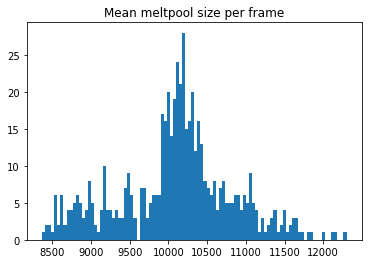

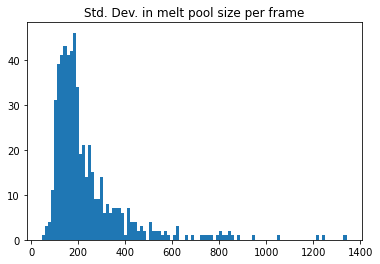

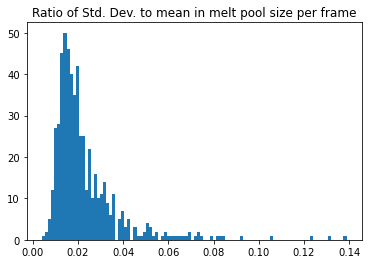

In [8]:
fig, ax = plt.subplots()
ax.hist(subset.groupby("matching_frame_filename").mean()["meltpoolSize"], bins=100)
ax.set_title("Mean meltpool size per frame")
plt.show()

fig, ax = plt.subplots()
ax.hist(subset.groupby("matching_frame_filename").std()["meltpoolSize"], bins=100)
ax.set_title("Std. Dev. in melt pool size per frame")
plt.show()

fig, ax = plt.subplots()
ax.hist(subset.groupby("matching_frame_filename").std()["meltpoolSize"] / subset.groupby("matching_frame_filename").mean()["meltpoolSize"], bins=100)
ax.set_title("Ratio of Std. Dev. to mean in melt pool size per frame")
plt.show()


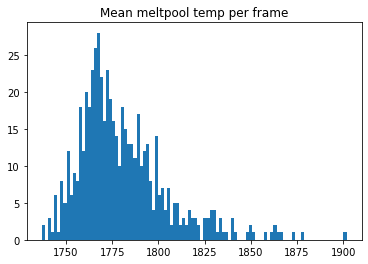

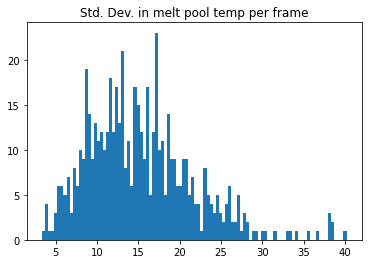

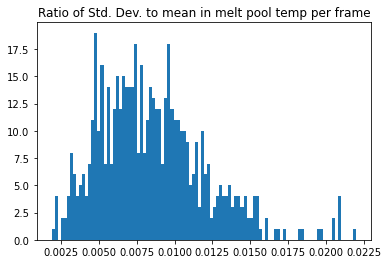

In [9]:
fig, ax = plt.subplots()
ax.hist(subset.groupby("matching_frame_filename").mean()["meltpoolTemp"], bins=100)
ax.set_title("Mean meltpool temp per frame")
plt.show()

fig, ax = plt.subplots()
ax.hist(subset.groupby("matching_frame_filename").std()["meltpoolTemp"], bins=100)
ax.set_title("Std. Dev. in melt pool temp per frame")
plt.show()

fig, ax = plt.subplots()
ax.hist(subset.groupby("matching_frame_filename").std()["meltpoolTemp"] / subset.groupby("matching_frame_filename").mean()["meltpoolTemp"], bins=100)
ax.set_title("Ratio of Std. Dev. to mean in melt pool temp per frame")
plt.show()


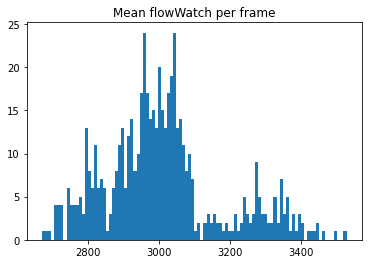

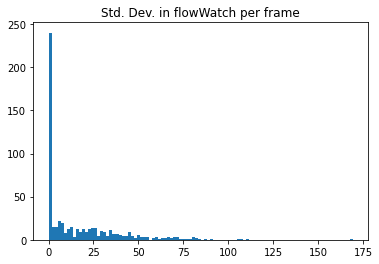

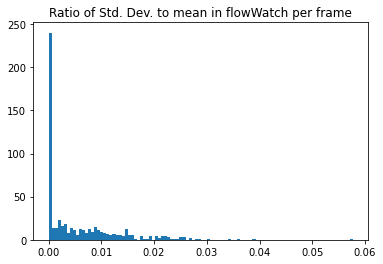

In [10]:
fig, ax = plt.subplots()
ax.hist(subset.groupby("matching_frame_filename").mean()["flowWatch"], bins=100)
ax.set_title("Mean flowWatch per frame")
plt.show()

fig, ax = plt.subplots()
ax.hist(subset.groupby("matching_frame_filename").std()["flowWatch"], bins=100)
ax.set_title("Std. Dev. in flowWatch per frame")
plt.show()

fig, ax = plt.subplots()
ax.hist(subset.groupby("matching_frame_filename").std()["flowWatch"] / subset.groupby("matching_frame_filename").mean()["flowWatch"], bins=100)
ax.set_title("Ratio of Std. Dev. to mean in flowWatch per frame")
plt.show()


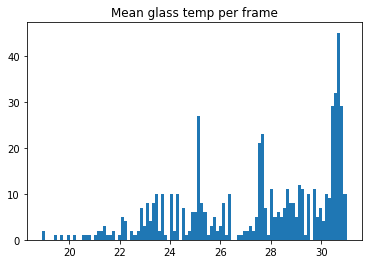

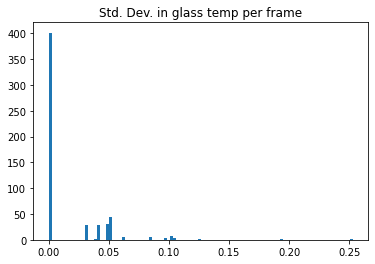

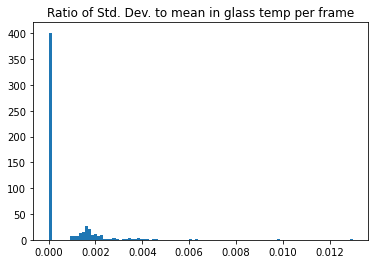

In [11]:
fig, ax = plt.subplots()
ax.hist(subset.groupby("matching_frame_filename").mean()["protectionGlasTemperature"], bins=100)
ax.set_title("Mean glass temp per frame")
plt.show()

fig, ax = plt.subplots()
ax.hist(subset.groupby("matching_frame_filename").std()["protectionGlasTemperature"], bins=100)
ax.set_title("Std. Dev. in glass temp per frame")
plt.show()

fig, ax = plt.subplots()
ax.hist(subset.groupby("matching_frame_filename").std()["protectionGlasTemperature"] / subset.groupby("matching_frame_filename").mean()["protectionGlasTemperature"], bins=100)
ax.set_title("Ratio of Std. Dev. to mean in glass temp per frame")
plt.show()


In [12]:
groupby = subset.groupby("matching_frame_filename").std()
groupby

,t,x,y,z,a,c,meltpoolSize,meltpoolTemp,LaserPower,stirrerValue_1,...,|v|(mm/ms),phi(rad),r(mm),phi_dot(rad/ms),laser_on_time(ms),laser_off_time(ms),xpart,ypart,zpart,toolpath_key
matching_frame_filename,,,,,,,,,,,,,,,,,,,,,
20210913_120208__36347.dat,302.765035,0.000000,0.000000,0.0,0.0,0.0,886.044268,27.133620,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,302.765035,0.0,0.000000,0.000000,0.0,0.0
20210913_120209__37348.dat,302.765035,0.000000,0.000000,0.0,0.0,0.0,658.219112,22.988886,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,302.765035,0.0,0.000000,0.000000,0.0,0.0
20210913_120210__38349.dat,302.765035,0.000000,0.000000,0.0,0.0,0.0,799.341875,20.424658,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,302.765035,0.0,0.000000,0.000000,0.0,0.0
20210913_120211__39350.dat,302.765035,5.675213,0.474342,0.0,0.0,0.0,789.807044,20.221276,0.0,0.0,...,0.004584,0.093561,5.656506,0.000752,302.765035,0.0,5.675213,0.474342,0.0,0.0
20210913_120212__40351.dat,302.765035,5.305336,0.000000,0.0,0.0,0.0,849.386085,22.703157,0.0,0.0,...,0.001963,0.011349,5.296923,0.000015,302.765035,0.0,5.305336,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20210913_121325__712967.dat,302.765035,5.045122,0.000000,0.0,0.0,0.0,249.396516,17.008495,0.0,0.0,...,0.001278,0.014958,5.034089,0.000023,302.765035,0.0,5.045122,0.000000,0.0,0.0
20210913_121326__713968.dat,302.765035,5.051029,0.000000,0.0,0.0,0.0,246.663266,22.978492,0.0,0.0,...,0.001516,0.631144,4.530783,0.003054,302.765035,0.0,5.051029,0.000000,0.0,0.0
20210913_121327__714968.dat,302.765035,5.061971,0.000000,0.0,0.0,0.0,217.623656,10.564090,0.0,0.0,...,0.000821,0.141812,4.967174,0.001083,302.765035,0.0,5.061971,0.000000,0.0,0.0


In [13]:
# Looking at extreme values in std dev
groupby[
    groupby["meltpoolSize"] > 1200
]

,t,x,y,z,a,c,meltpoolSize,meltpoolTemp,LaserPower,stirrerValue_1,...,|v|(mm/ms),phi(rad),r(mm),phi_dot(rad/ms),laser_on_time(ms),laser_off_time(ms),xpart,ypart,zpart,toolpath_key
matching_frame_filename,,,,,,,,,,,,,,,,,,,,,
20210913_120807__395676.dat,302.765035,5.080229,0.0,0.0,0.0,0.0,1341.638555,9.366607,0.0,0.0,...,0.003345,0.003692,5.077470,0.000003,302.765035,0.0,5.080229,0.0,0.0,0.0
20210913_120849__436714.dat,302.765035,5.261123,0.0,0.0,0.0,0.0,1241.332098,28.128475,0.0,0.0,...,0.002183,0.003707,5.258354,0.000003,302.765035,0.0,5.261123,0.0,0.0,0.0
20210913_120930__477752.dat,302.765035,5.331004,0.0,0.0,0.0,0.0,1212.687759,21.024853,0.0,0.0,...,0.004785,0.003720,5.328226,0.000005,302.765035,0.0,5.331004,0.0,0.0,0.0


In [14]:
data_df[
    data_df["matching_frame_filename"] == "20210913_120849__436714.dat"
]

,t,x,y,z,a,c,meltpoolSize,meltpoolTemp,LaserPower,stirrerValue_1,...,phi(rad),r(mm),phi_dot(rad/ms),laser_on_time(ms),laser_off_time(ms),xpart,ypart,zpart,toolpath_key,matching_frame_filename
4009,436302,-38.926,-1.5,30.21,0.0,0.0,10066,1835.0,1400,0,...,-3.103077,38.954890,-0.000017,5800,0,-38.926,-1.5,30.21,57.0,20210913_120849__436714.dat
4010,436402,-40.593,-1.5,30.21,0.0,0.0,9853,1812.0,1400,0,...,-3.104657,40.620705,-0.000015,5900,0,-40.593,-1.5,30.21,57.0,20210913_120849__436714.dat
4011,436502,-42.260,-1.5,30.21,0.0,0.0,9700,1822.0,1400,0,...,-3.106113,42.286613,-0.000014,6000,0,-42.260,-1.5,30.21,57.0,20210913_120849__436714.dat
4012,436602,-43.926,-1.5,30.21,0.0,0.0,10339,1831.0,1400,0,...,-3.107458,43.951604,-0.000013,6100,0,-43.926,-1.5,30.21,57.0,20210913_120849__436714.dat
4013,436702,-45.593,-1.5,30.21,0.0,0.0,10160,1853.0,1400,0,...,-3.108705,45.617668,-0.000012,6200,0,-45.593,-1.5,30.21,57.0,20210913_120849__436714.dat
4014,436802,-47.260,-1.5,30.21,0.0,0.0,10613,1859.0,1400,0,...,-3.109864,47.283798,-0.000013,6300,0,-47.260,-1.5,30.21,57.0,20210913_120849__436714.dat
4015,436902,-49.526,-1.5,30.21,0.0,0.0,10194,1828.0,1400,0,...,-3.111315,49.548710,-0.000012,6400,0,-49.526,-1.5,30.21,57.0,20210913_120849__436714.dat
4016,437002,-51.060,-1.5,30.21,0.0,0.0,9192,1848.0,1400,0,...,-3.112224,51.082028,-0.000009,6500,0,-51.060,-1.5,30.21,57.0,20210913_120849__436714.dat
4017,437102,-52.726,-1.5,30.21,0.0,0.0,7759,1841.0,1400,0,...,-3.113151,52.747332,-0.000009,6600,0,-52.726,-1.5,30.21,57.0,20210913_120849__436714.dat
4018,437202,-54.393,-1.5,30.21,0.0,0.0,6778,1760.0,1400,0,...,-3.114023,54.413679,-0.000006,6700,0,-54.393,-1.5,30.21,57.0,20210913_120849__436714.dat


In [15]:
# Looking at previous value, find neighbours, I think this is when it's about to turn
data_df[
    (data_df["t"] > 436102)
    & (data_df["t"] < 438302)
]

,t,x,y,z,a,c,meltpoolSize,meltpoolTemp,LaserPower,stirrerValue_1,...,phi(rad),r(mm),phi_dot(rad/ms),laser_on_time(ms),laser_off_time(ms),xpart,ypart,zpart,toolpath_key,matching_frame_filename
4008,436202,-37.260,-1.5,30.21,0.0,0.0,10233,1833.0,1400,0,...,-3.101357,37.290181,-0.000018,5700,0,-37.260,-1.5,30.21,57.0,20210913_120848__435714.dat
4009,436302,-38.926,-1.5,30.21,0.0,0.0,10066,1835.0,1400,0,...,-3.103077,38.954890,-0.000017,5800,0,-38.926,-1.5,30.21,57.0,20210913_120849__436714.dat
4010,436402,-40.593,-1.5,30.21,0.0,0.0,9853,1812.0,1400,0,...,-3.104657,40.620705,-0.000015,5900,0,-40.593,-1.5,30.21,57.0,20210913_120849__436714.dat
4011,436502,-42.260,-1.5,30.21,0.0,0.0,9700,1822.0,1400,0,...,-3.106113,42.286613,-0.000014,6000,0,-42.260,-1.5,30.21,57.0,20210913_120849__436714.dat
4012,436602,-43.926,-1.5,30.21,0.0,0.0,10339,1831.0,1400,0,...,-3.107458,43.951604,-0.000013,6100,0,-43.926,-1.5,30.21,57.0,20210913_120849__436714.dat
4013,436702,-45.593,-1.5,30.21,0.0,0.0,10160,1853.0,1400,0,...,-3.108705,45.617668,-0.000012,6200,0,-45.593,-1.5,30.21,57.0,20210913_120849__436714.dat
4014,436802,-47.260,-1.5,30.21,0.0,0.0,10613,1859.0,1400,0,...,-3.109864,47.283798,-0.000013,6300,0,-47.260,-1.5,30.21,57.0,20210913_120849__436714.dat
4015,436902,-49.526,-1.5,30.21,0.0,0.0,10194,1828.0,1400,0,...,-3.111315,49.548710,-0.000012,6400,0,-49.526,-1.5,30.21,57.0,20210913_120849__436714.dat
4016,437002,-51.060,-1.5,30.21,0.0,0.0,9192,1848.0,1400,0,...,-3.112224,51.082028,-0.000009,6500,0,-51.060,-1.5,30.21,57.0,20210913_120849__436714.dat
4017,437102,-52.726,-1.5,30.21,0.0,0.0,7759,1841.0,1400,0,...,-3.113151,52.747332,-0.000009,6600,0,-52.726,-1.5,30.21,57.0,20210913_120849__436714.dat


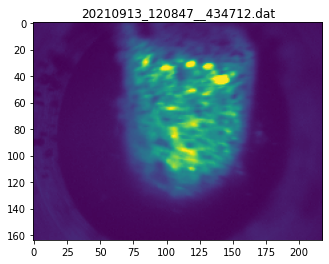

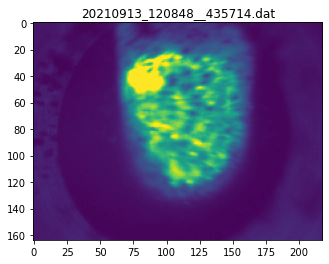

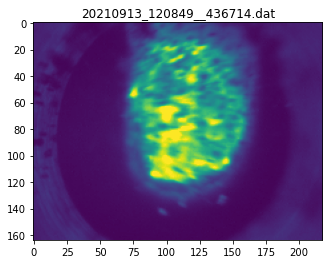

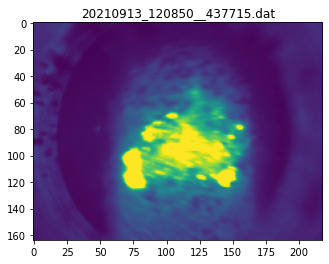

In [16]:
# Get frames
frame_folder_path = os.path.join(dataset_path, "Frames")
# Frames to inspect
frame_names = np.unique(data_df[
    (data_df["t"] > 435102)
    & (data_df["t"] < 438302)
]["matching_frame_filename"])
frame_paths = [os.path.join(frame_folder_path, i) for i in frame_names]
frames = [tools.read_and_convert_image(i) for i in frame_paths]

for frame, name in zip(frames, frame_names):
    fig, ax = plt.subplots()
    ax.imshow(frame)
    ax.set_title(name)
    plt.show()

NOTE1 

Note that the path of travel turns between the third and fourth image

So, just looking at these values, we can see a dropoff in pool size as it nears the end of travel. Perhaps there's not enough material present for a pool to build up?

In [17]:
# Looking at extreme values in std dev
groupby[
    groupby["meltpoolSize"] > 1200
]

,t,x,y,z,a,c,meltpoolSize,meltpoolTemp,LaserPower,stirrerValue_1,...,|v|(mm/ms),phi(rad),r(mm),phi_dot(rad/ms),laser_on_time(ms),laser_off_time(ms),xpart,ypart,zpart,toolpath_key
matching_frame_filename,,,,,,,,,,,,,,,,,,,,,
20210913_120807__395676.dat,302.765035,5.080229,0.0,0.0,0.0,0.0,1341.638555,9.366607,0.0,0.0,...,0.003345,0.003692,5.077470,0.000003,302.765035,0.0,5.080229,0.0,0.0,0.0
20210913_120849__436714.dat,302.765035,5.261123,0.0,0.0,0.0,0.0,1241.332098,28.128475,0.0,0.0,...,0.002183,0.003707,5.258354,0.000003,302.765035,0.0,5.261123,0.0,0.0,0.0
20210913_120930__477752.dat,302.765035,5.331004,0.0,0.0,0.0,0.0,1212.687759,21.024853,0.0,0.0,...,0.004785,0.003720,5.328226,0.000005,302.765035,0.0,5.331004,0.0,0.0,0.0


In [18]:
# Select a subset with one of the frame names that had high variation in meltpool size
suspect_frame_name = "20210913_120807__395676.dat"
x = data_df[
    data_df["matching_frame_filename"] == suspect_frame_name
]
# Get some values after the end of that set, to see if there's a turn coming up
x = data_df[
    (data_df["matching_frame_filename"] == suspect_frame_name)
    | (
        (data_df["t"] < x["t"].max() + 500)
        & ((data_df["t"] > x["t"].min() + 500))
    )
]
x

,t,x,y,z,a,c,meltpoolSize,meltpoolTemp,LaserPower,stirrerValue_1,...,phi(rad),r(mm),phi_dot(rad/ms),laser_on_time(ms),laser_off_time(ms),xpart,ypart,zpart,toolpath_key,matching_frame_filename
3598,395202,-39.126,-1.5,27.030,0.0,0.0,10055,1836.0,1400,0,...,-3.103274,39.154743,-8.512094e-06,5700,0,-39.126,-1.5,27.030,51.0,20210913_120807__395676.dat
3599,395302,-39.126,-1.5,27.030,0.0,0.0,10217,1828.0,1400,0,...,-3.103274,39.154743,-1.221567e-05,5800,0,-39.126,-1.5,27.030,51.0,20210913_120807__395676.dat
3600,395402,-41.793,-1.5,27.030,0.0,0.0,10483,1849.0,1400,0,...,-3.105717,41.819910,-1.909056e-05,5900,0,-41.793,-1.5,27.030,51.0,20210913_120807__395676.dat
3601,395502,-43.460,-1.5,27.030,0.0,0.0,10237,1817.0,1400,0,...,-3.107092,43.485878,-1.323876e-05,6000,0,-43.460,-1.5,27.030,51.0,20210913_120807__395676.dat
3602,395602,-45.126,-1.5,27.030,0.0,0.0,10302,1838.0,1400,0,...,-3.108365,45.150923,-1.227849e-05,6100,0,-45.126,-1.5,27.030,51.0,20210913_120807__395676.dat
3603,395702,-46.793,-1.5,27.030,0.0,0.0,10350,1829.0,1400,0,...,-3.109548,46.817036,-1.142271e-05,6200,0,-46.793,-1.5,27.030,51.0,20210913_120807__395676.dat
3604,395802,-48.460,-1.5,27.030,0.0,0.0,10419,1833.0,1400,0,...,-3.110649,48.483209,-1.064720e-05,6300,0,-48.460,-1.5,27.030,51.0,20210913_120807__395676.dat
3605,395902,-50.126,-1.5,27.030,0.0,0.0,9987,1826.0,1400,0,...,-3.111677,50.148438,-9.950671e-06,6400,0,-50.126,-1.5,27.030,51.0,20210913_120807__395676.dat
3606,396002,-51.793,-1.5,27.030,0.0,0.0,8247,1827.0,1400,0,...,-3.112639,51.814717,-9.323304e-06,6500,0,-51.793,-1.5,27.030,51.0,20210913_120807__395676.dat
3607,396102,-53.460,-1.5,27.030,0.0,0.0,6320,1819.0,1400,0,...,-3.113542,53.481040,-8.402211e-06,6600,0,-53.460,-1.5,27.030,51.0,20210913_120807__395676.dat


NOTE1

The above block shows that meltpool size starts dropping off at the end of travel, before the laser switches off

Lets quickly have a look at what happens if we reject some of the extremes of travel

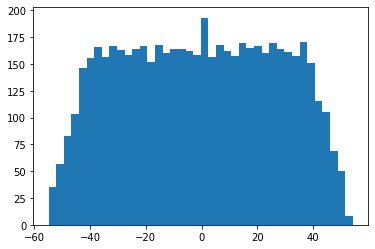

In [19]:
fig, ax = plt.subplots()
ax.hist(subset["x"], bins=40)
# ax.hist(subset["y"], color="#FF000088")
plt.show()

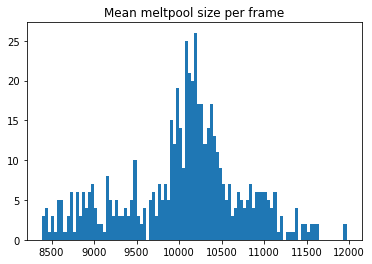

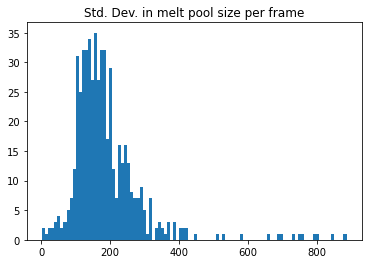

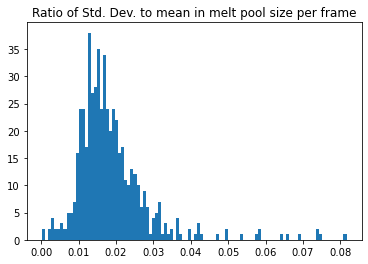

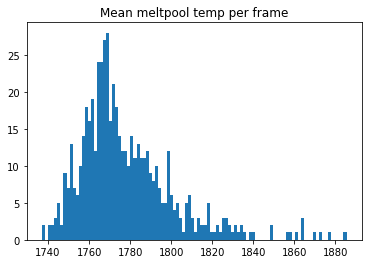

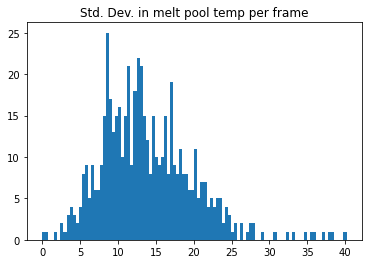

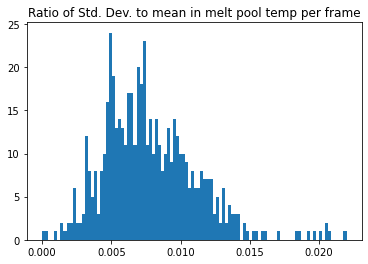

In [20]:
subset_2 = subset[
    np.abs(subset["x"]) < 40
]

fig, ax = plt.subplots()
ax.hist(subset_2.groupby("matching_frame_filename").mean()["meltpoolSize"], bins=100)
ax.set_title("Mean meltpool size per frame")
plt.show()

fig, ax = plt.subplots()
ax.hist(subset_2.groupby("matching_frame_filename").std()["meltpoolSize"], bins=100)
ax.set_title("Std. Dev. in melt pool size per frame")
plt.show()

fig, ax = plt.subplots()
ax.hist(subset_2.groupby("matching_frame_filename").std()["meltpoolSize"] / subset_2.groupby("matching_frame_filename").mean()["meltpoolSize"], bins=100)
ax.set_title("Ratio of Std. Dev. to mean in melt pool size per frame")
plt.show()

fig, ax = plt.subplots()
ax.hist(subset_2.groupby("matching_frame_filename").mean()["meltpoolTemp"], bins=100)
ax.set_title("Mean meltpool temp per frame")
plt.show()

fig, ax = plt.subplots()
ax.hist(subset_2.groupby("matching_frame_filename").std()["meltpoolTemp"], bins=100)
ax.set_title("Std. Dev. in melt pool temp per frame")
plt.show()

fig, ax = plt.subplots()
ax.hist(subset_2.groupby("matching_frame_filename").std()["meltpoolTemp"] / subset_2.groupby("matching_frame_filename").mean()["meltpoolTemp"], bins=100)
ax.set_title("Ratio of Std. Dev. to mean in melt pool temp per frame")
plt.show()


In [21]:
groupby_2 = subset_2.groupby("matching_frame_filename").std()
groupby_2[
    groupby_2["meltpoolSize"] > 600
]

,t,x,y,z,a,c,meltpoolSize,meltpoolTemp,LaserPower,stirrerValue_1,...,|v|(mm/ms),phi(rad),r(mm),phi_dot(rad/ms),laser_on_time(ms),laser_off_time(ms),xpart,ypart,zpart,toolpath_key
matching_frame_filename,,,,,,,,,,,,,,,,,,,,,
20210913_120208__36347.dat,302.765035,0.000000,0.000000,0.0,0.0,0.0,886.044268,27.133620,0.0,0.0,...,0.000000e+00,0.000000,0.000000,0.000000,302.765035,0.0,0.000000,0.000000,0.0,0.0
20210913_120209__37348.dat,302.765035,0.000000,0.000000,0.0,0.0,0.0,658.219112,22.988886,0.0,0.0,...,0.000000e+00,0.000000,0.000000,0.000000,302.765035,0.0,0.000000,0.000000,0.0,0.0
20210913_120210__38349.dat,302.765035,0.000000,0.000000,0.0,0.0,0.0,799.341875,20.424658,0.0,0.0,...,0.000000e+00,0.000000,0.000000,0.000000,302.765035,0.0,0.000000,0.000000,0.0,0.0
20210913_120211__39350.dat,302.765035,5.675213,0.474342,0.0,0.0,0.0,789.807044,20.221276,0.0,0.0,...,4.584406e-03,0.093561,5.656506,0.000752,302.765035,0.0,5.675213,0.474342,0.0,0.0
20210913_120212__40351.dat,302.765035,5.305336,0.000000,0.0,0.0,0.0,849.386085,22.703157,0.0,0.0,...,1.963432e-03,0.011349,5.296923,0.000015,302.765035,0.0,5.305336,0.000000,0.0,0.0
20210913_120213__41352.dat,70.710678,1.178040,0.000000,0.0,0.0,0.0,697.207286,27.577164,0.0,0.0,...,1.962616e-17,0.001242,1.177108,0.000001,70.710678,0.0,1.178040,0.000000,0.0,0.0
20210913_120215__43353.dat,216.024690,3.147091,0.000000,0.0,0.0,0.0,683.811726,14.842025,0.0,0.0,...,3.477963e-03,0.004117,3.144009,0.000007,216.024690,0.0,3.147091,0.000000,0.0,0.0
20210913_120216__44354.dat,302.765035,5.133240,0.000000,0.0,0.0,0.0,751.871620,38.119112,0.0,0.0,...,1.277998e-03,0.020669,5.118061,0.000039,302.765035,0.0,5.133240,0.000000,0.0,0.0
20210913_120218__46356.dat,302.765035,5.149041,0.000000,0.0,0.0,0.0,730.069829,38.472068,0.0,0.0,...,4.196229e-03,0.057725,5.107939,0.000214,302.765035,0.0,5.149041,0.000000,0.0,0.0


In [22]:
# Select a subset with one of the frame names that had high variation in meltpool size
suspect_frame_name = "20210913_120212__40351.dat"
x = data_df[
    data_df["matching_frame_filename"] == suspect_frame_name
]
# Get some values after the end of that set, to see if there's a turn coming up
x = data_df[
    (data_df["matching_frame_filename"] == suspect_frame_name)
    | (
        (data_df["t"] < x["t"].max() + 1000)
        & ((data_df["t"] > x["t"].min()))
    )
]
x

,t,x,y,z,a,c,meltpoolSize,meltpoolTemp,LaserPower,stirrerValue_1,...,phi(rad),r(mm),phi_dot(rad/ms),laser_on_time(ms),laser_off_time(ms),xpart,ypart,zpart,toolpath_key,matching_frame_filename
45,39899,19.660,-1.5,0.0,0.0,0.0,12357,1909.0,2000,0,...,-0.076150,19.717140,0.000065,4500,0,19.660,-1.5,0.0,0.0,20210913_120212__40351.dat
46,39999,21.326,-1.5,0.0,0.0,0.0,12480,1899.0,2000,0,...,-0.070221,21.378687,0.000055,4600,0,21.326,-1.5,0.0,0.0,20210913_120212__40351.dat
47,40099,22.993,-1.5,0.0,0.0,0.0,11797,1887.0,2000,0,...,-0.065145,23.041876,0.000047,4700,0,22.993,-1.5,0.0,0.0,20210913_120212__40351.dat
48,40199,24.660,-1.5,0.0,0.0,0.0,10492,1858.0,2000,0,...,-0.060752,24.705578,0.000041,4800,0,24.660,-1.5,0.0,0.0,20210913_120212__40351.dat
49,40299,26.326,-1.5,0.0,0.0,0.0,10303,1842.0,2000,0,...,-0.056916,26.368699,0.000045,4900,0,26.326,-1.5,0.0,0.0,20210913_120212__40351.dat
50,40399,28.993,-1.5,0.0,0.0,0.0,10111,1851.0,2000,0,...,-0.051691,29.031777,0.000036,5000,0,28.993,-1.5,0.0,0.0,20210913_120212__40351.dat
51,40499,30.193,-1.5,0.0,0.0,0.0,11076,1863.0,2000,0,...,-0.049640,30.230237,0.000023,5100,0,30.193,-1.5,0.0,0.0,20210913_120212__40351.dat
52,40599,31.860,-1.5,0.0,0.0,0.0,11535,1886.0,2000,0,...,-0.047046,31.895291,0.000025,5200,0,31.860,-1.5,0.0,0.0,20210913_120212__40351.dat
53,40699,33.526,-1.5,0.0,0.0,0.0,12068,1887.0,2000,0,...,-0.044712,33.559539,0.000022,5300,0,33.526,-1.5,0.0,0.0,20210913_120212__40351.dat
54,40799,35.193,-1.5,0.0,0.0,0.0,11466,1897.0,2000,0,...,-0.042596,35.224952,0.000020,5400,0,35.193,-1.5,0.0,0.0,20210913_120212__40351.dat


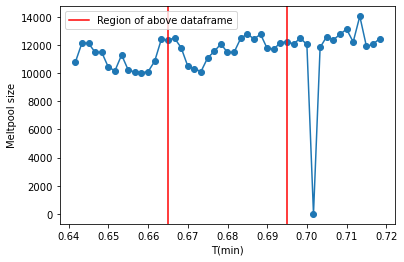

In [23]:
# Plot the meltpool size around this pt 
# We'll extend to show teh neighbours
y = data_df[
    (data_df["t"] > x["t"].min() - 1500)
    & (data_df["t"] < x["t"].max() + 1500)
]
fig, ax = plt.subplots()
ax.plot(y["t(min)"], y["meltpoolSize"], marker='o')
ax.set_xlabel("T(min)")
ax.set_ylabel("Meltpool size")
ax.axvline(x["t(min)"].min(), color="#FF0000FF", label="Region of above dataframe")
ax.axvline(x["t(min)"].max(), color="#FF0000FF")
ax.legend()
plt.show()

In the above plot I have a look at one of teh central sections where pool size seems to fluctuate a bit.

Nothing quite drops out when we look at it with the context of its neighbours

It is close to the end however

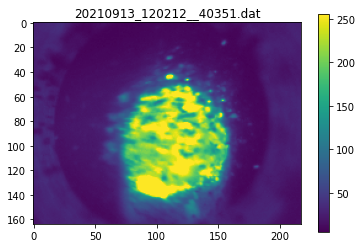

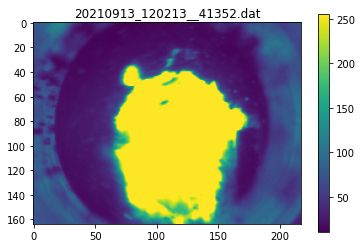

In [24]:
# Get frames
frame_folder_path = os.path.join(dataset_path, "Frames")
# Frames to inspect
frame_names = np.unique(x["matching_frame_filename"])
frame_paths = [os.path.join(frame_folder_path, i) for i in frame_names]
frames = [tools.read_and_convert_image(i) for i in frame_paths]

for frame, name in zip(frames, frame_names):
    fig, ax = plt.subplots()
    imshow_result = ax.imshow(frame)
    ax.set_title(name)
    fig.colorbar(imshow_result)
    plt.show()

Try looking at another suspect frame

In [25]:
groupby_2 = subset_2.groupby("matching_frame_filename").std()
groupby_2[
    groupby_2["meltpoolSize"] > 600
]

,t,x,y,z,a,c,meltpoolSize,meltpoolTemp,LaserPower,stirrerValue_1,...,|v|(mm/ms),phi(rad),r(mm),phi_dot(rad/ms),laser_on_time(ms),laser_off_time(ms),xpart,ypart,zpart,toolpath_key
matching_frame_filename,,,,,,,,,,,,,,,,,,,,,
20210913_120208__36347.dat,302.765035,0.000000,0.000000,0.0,0.0,0.0,886.044268,27.133620,0.0,0.0,...,0.000000e+00,0.000000,0.000000,0.000000,302.765035,0.0,0.000000,0.000000,0.0,0.0
20210913_120209__37348.dat,302.765035,0.000000,0.000000,0.0,0.0,0.0,658.219112,22.988886,0.0,0.0,...,0.000000e+00,0.000000,0.000000,0.000000,302.765035,0.0,0.000000,0.000000,0.0,0.0
20210913_120210__38349.dat,302.765035,0.000000,0.000000,0.0,0.0,0.0,799.341875,20.424658,0.0,0.0,...,0.000000e+00,0.000000,0.000000,0.000000,302.765035,0.0,0.000000,0.000000,0.0,0.0
20210913_120211__39350.dat,302.765035,5.675213,0.474342,0.0,0.0,0.0,789.807044,20.221276,0.0,0.0,...,4.584406e-03,0.093561,5.656506,0.000752,302.765035,0.0,5.675213,0.474342,0.0,0.0
20210913_120212__40351.dat,302.765035,5.305336,0.000000,0.0,0.0,0.0,849.386085,22.703157,0.0,0.0,...,1.963432e-03,0.011349,5.296923,0.000015,302.765035,0.0,5.305336,0.000000,0.0,0.0
20210913_120213__41352.dat,70.710678,1.178040,0.000000,0.0,0.0,0.0,697.207286,27.577164,0.0,0.0,...,1.962616e-17,0.001242,1.177108,0.000001,70.710678,0.0,1.178040,0.000000,0.0,0.0
20210913_120215__43353.dat,216.024690,3.147091,0.000000,0.0,0.0,0.0,683.811726,14.842025,0.0,0.0,...,3.477963e-03,0.004117,3.144009,0.000007,216.024690,0.0,3.147091,0.000000,0.0,0.0
20210913_120216__44354.dat,302.765035,5.133240,0.000000,0.0,0.0,0.0,751.871620,38.119112,0.0,0.0,...,1.277998e-03,0.020669,5.118061,0.000039,302.765035,0.0,5.133240,0.000000,0.0,0.0
20210913_120218__46356.dat,302.765035,5.149041,0.000000,0.0,0.0,0.0,730.069829,38.472068,0.0,0.0,...,4.196229e-03,0.057725,5.107939,0.000214,302.765035,0.0,5.149041,0.000000,0.0,0.0


In [26]:
# Select a subset with one of the frame names that had high variation in meltpool size
suspect_frame_name = "20210913_120218__46356.dat"
x = data_df[
    data_df["matching_frame_filename"] == suspect_frame_name
]
# Get some values after the end of that set, to see if there's a turn coming up
x = data_df[
    (data_df["matching_frame_filename"] == suspect_frame_name)
    | (
        (data_df["t"] < x["t"].max() + 1000)
        & ((data_df["t"] > x["t"].min()))
    )
]
print(x["meltpoolThreshold"].unique())
x

[506]


,t,x,y,z,a,c,meltpoolSize,meltpoolTemp,LaserPower,stirrerValue_1,...,phi(rad),r(mm),phi_dot(rad/ms),laser_on_time(ms),laser_off_time(ms),xpart,ypart,zpart,toolpath_key,matching_frame_filename
105,45899,-5.926,-1.5,0.53,0.0,0.0,10459,1797.0,2000,0,...,-2.893678,6.112894,-0.000718,3800,0,-5.926,-1.5,0.53,1.0,20210913_120218__46356.dat
106,45999,-7.593,-1.5,0.53,0.0,0.0,11017,1836.0,2000,0,...,-2.946554,7.739745,-0.000437,3900,0,-7.593,-1.5,0.53,1.0,20210913_120218__46356.dat
107,46099,-9.260,-1.5,0.53,0.0,0.0,10188,1783.0,2000,0,...,-2.981001,9.380704,-0.000293,4000,0,-9.260,-1.5,0.53,1.0,20210913_120218__46356.dat
108,46199,-10.926,-1.5,0.53,0.0,0.0,10541,1815.0,2000,0,...,-3.005158,11.028485,-0.000210,4100,0,-10.926,-1.5,0.53,1.0,20210913_120218__46356.dat
109,46299,-12.593,-1.5,0.53,0.0,0.0,11682,1866.0,2000,0,...,-3.023037,12.682021,-0.000158,4200,0,-12.593,-1.5,0.53,1.0,20210913_120218__46356.dat
110,46399,-14.260,-1.5,0.53,0.0,0.0,11716,1876.0,2000,0,...,-3.036789,14.338675,-0.000146,4300,0,-14.260,-1.5,0.53,1.0,20210913_120218__46356.dat
111,46499,-16.726,-1.5,0.53,0.0,0.0,11748,1872.0,2000,0,...,-3.052151,16.793126,-0.000117,4400,0,-16.726,-1.5,0.53,1.0,20210913_120218__46356.dat
112,46599,-18.393,-1.5,0.53,0.0,0.0,12371,1886.0,2000,0,...,-3.060220,18.454063,-0.000074,4500,0,-18.393,-1.5,0.53,1.0,20210913_120218__46356.dat
113,46699,-20.060,-1.5,0.53,0.0,0.0,11947,1873.0,2000,0,...,-3.066956,20.116004,-0.000034,4600,0,-20.060,-1.5,0.53,1.0,20210913_120218__46356.dat
114,46799,-20.060,-1.5,0.53,0.0,0.0,11649,1887.0,2000,0,...,-3.066956,20.116004,-0.000030,4700,0,-20.060,-1.5,0.53,1.0,20210913_120218__46356.dat


Okay, so larger variations do show up at times, but the frame periods are so small it may be hard to tell?

Will look further

Also we should look at autocorrelations

# Part two: Do all the data sets in sequence

## First, thin wall:


['20210831_1127_', '20210831_1615_', '20210902_1550_', '20210906_0918_', '20210906_1019_', '20210906_1339_', '20210913_0928_', 'ngif-wall']
Data path C:\Users\Scott Williams\Documents\programming\ngif_romar\data\ngif_data_thinwall\ngif data\20210831_1127_\Data.dat
['Data.dat', 'Frames']
Number of rows: 6910, head:


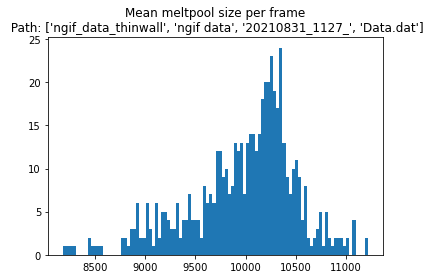

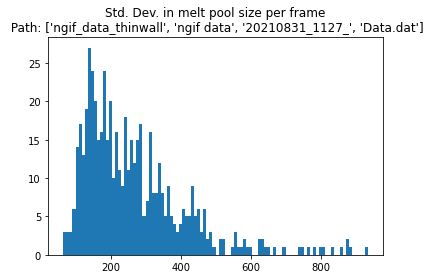

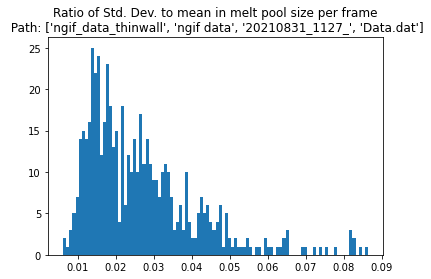

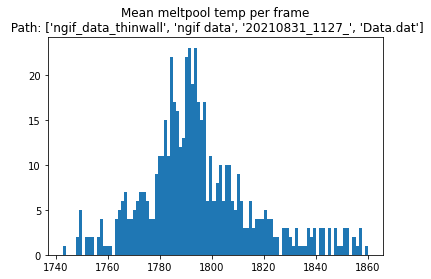

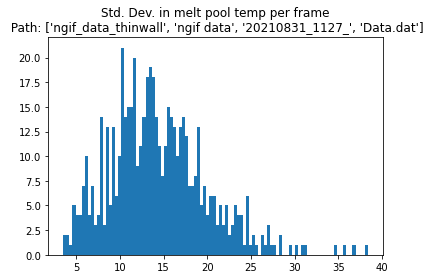

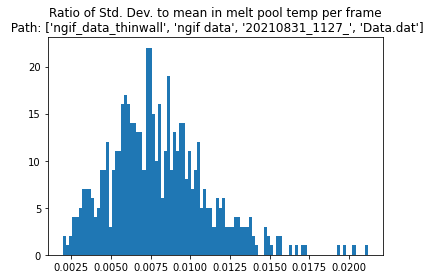

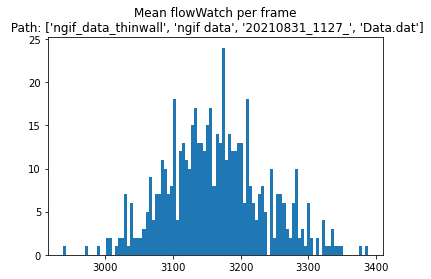

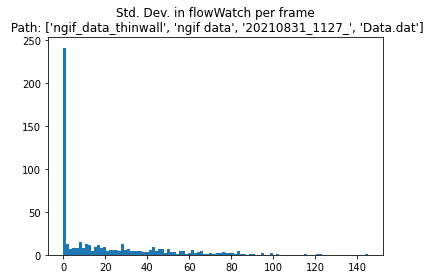

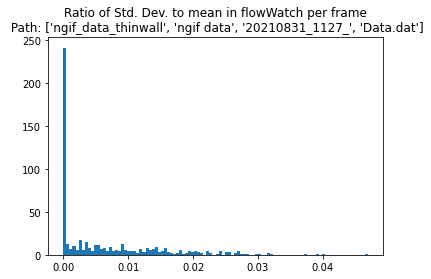

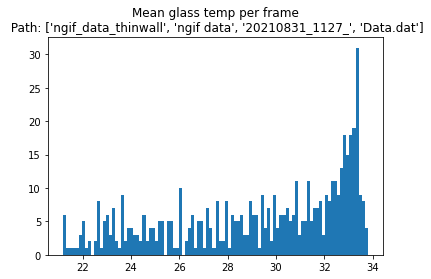

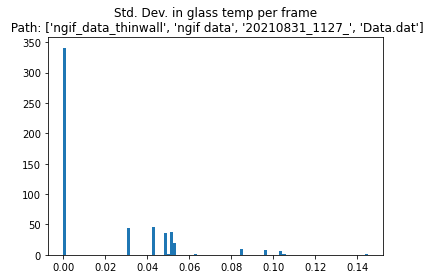

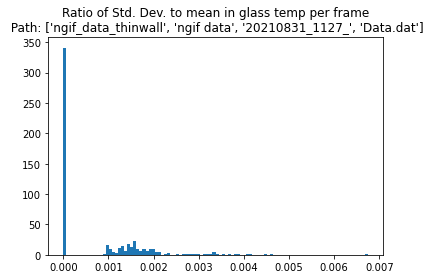

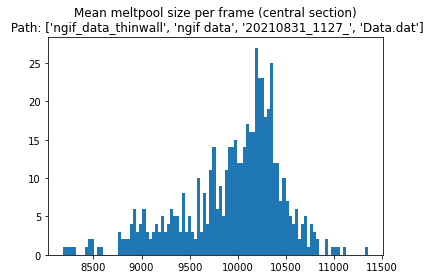

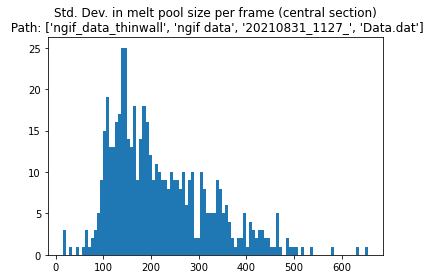

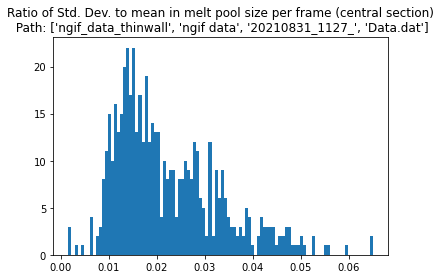

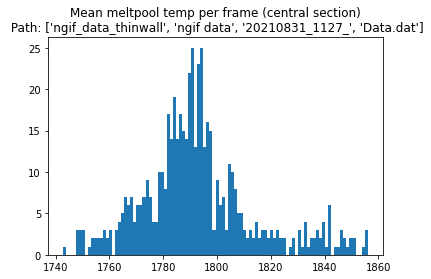

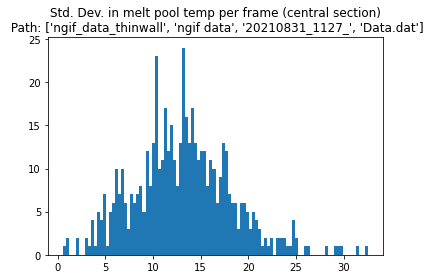

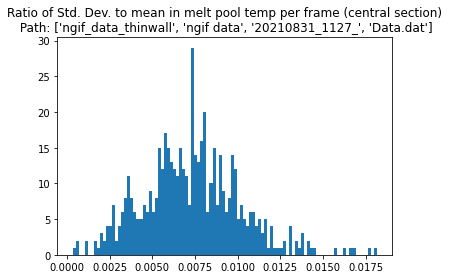

Data path C:\Users\Scott Williams\Documents\programming\ngif_romar\data\ngif_data_thinwall\ngif data\20210831_1615_\Data.dat
['Data.dat', 'Frames']
Number of rows: 6908, head:


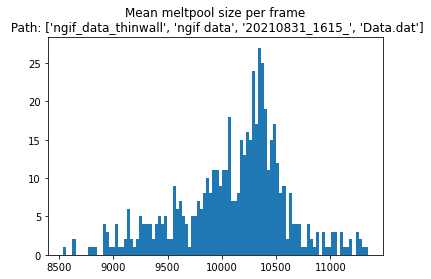

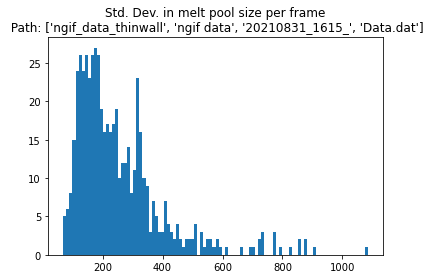

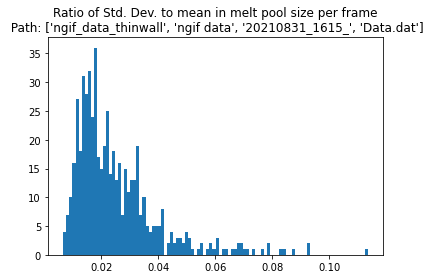

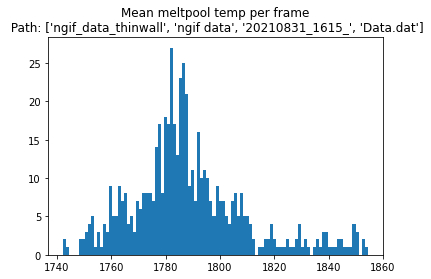

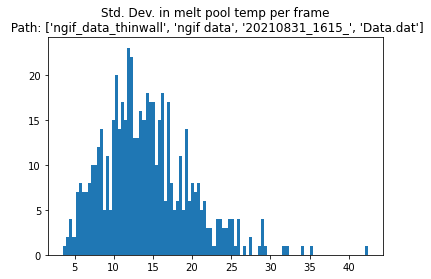

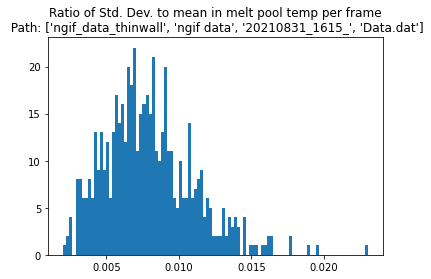

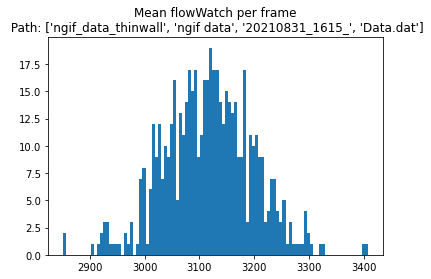

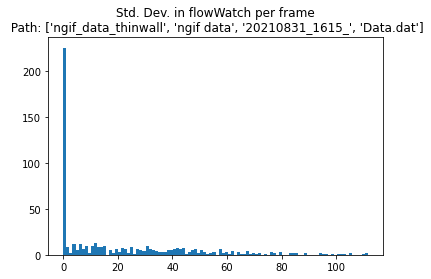

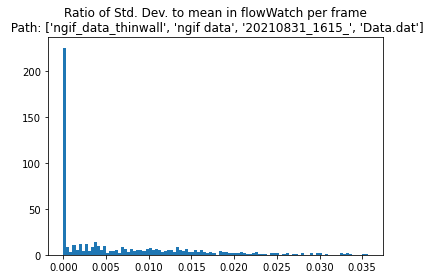

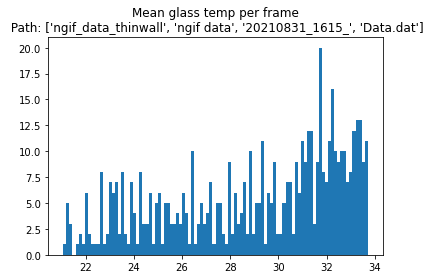

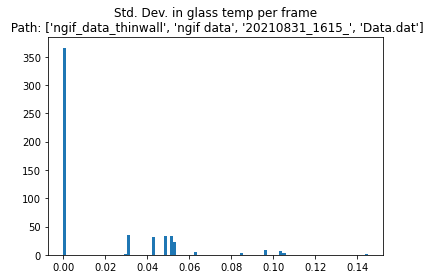

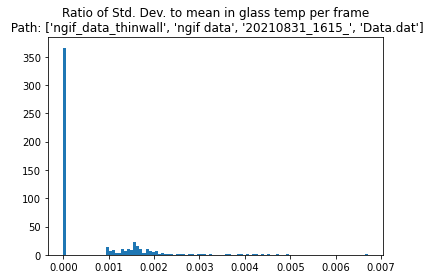

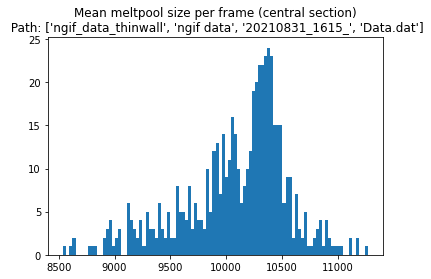

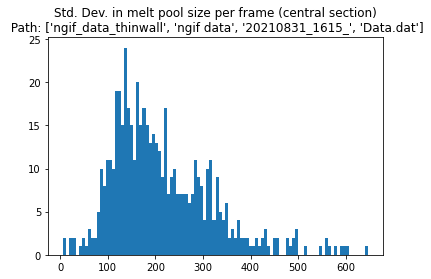

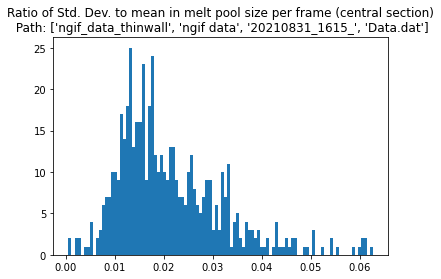

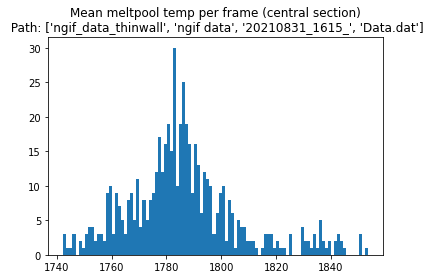

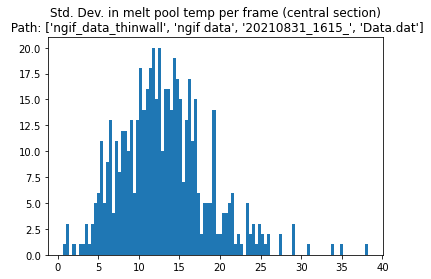

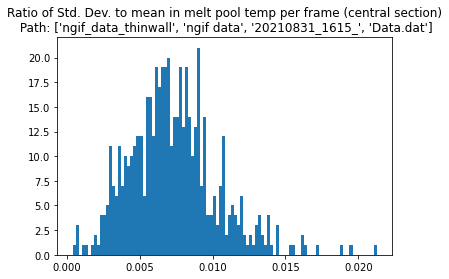

Data path C:\Users\Scott Williams\Documents\programming\ngif_romar\data\ngif_data_thinwall\ngif data\20210902_1550_\Data.dat
['Data.dat', 'Frames']
Number of rows: 6908, head:


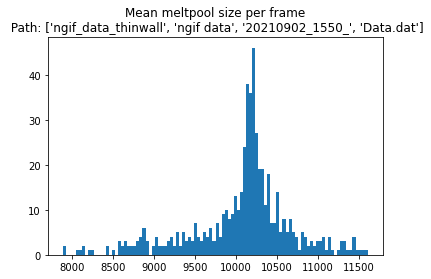

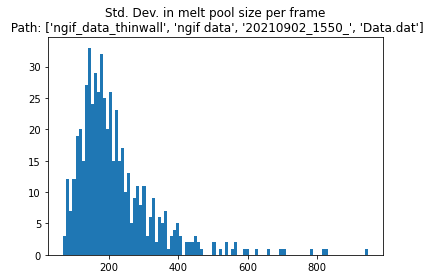

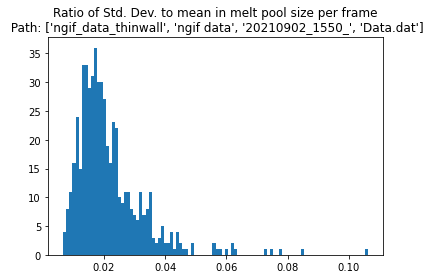

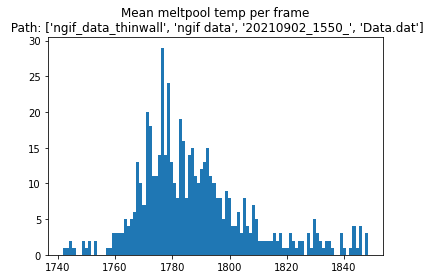

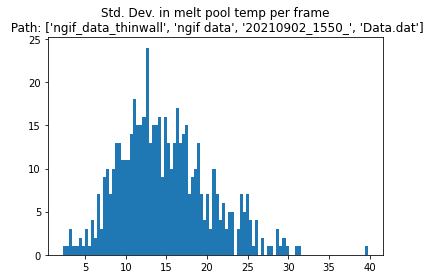

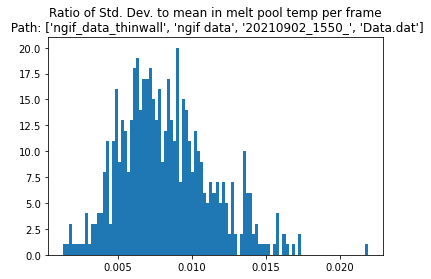

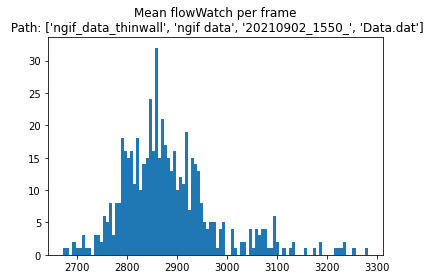

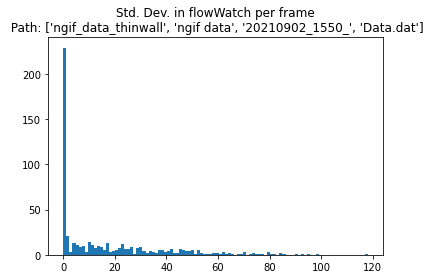

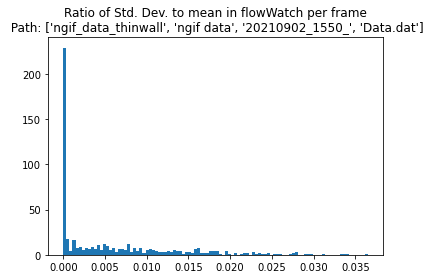

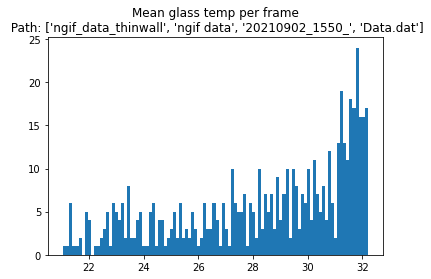

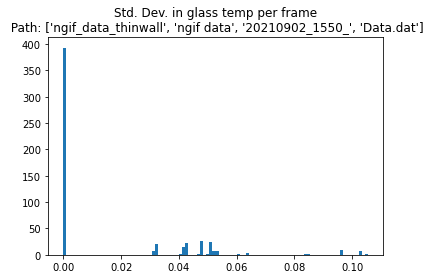

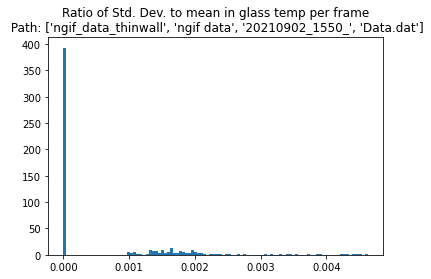

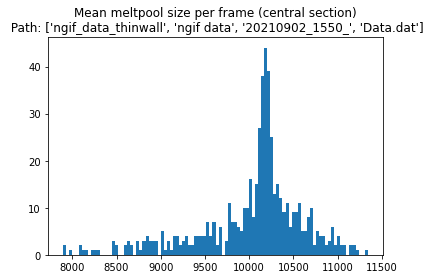

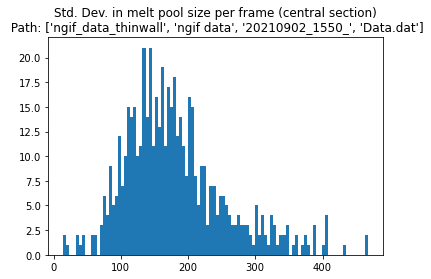

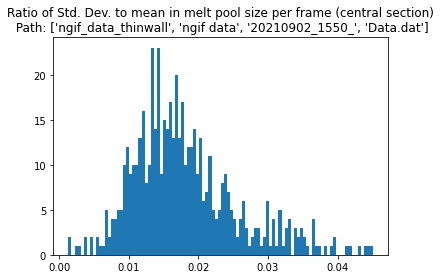

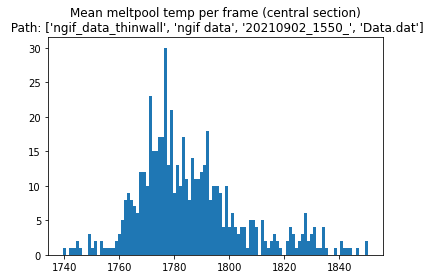

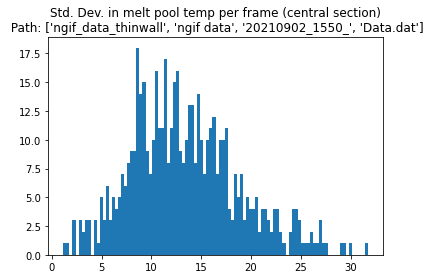

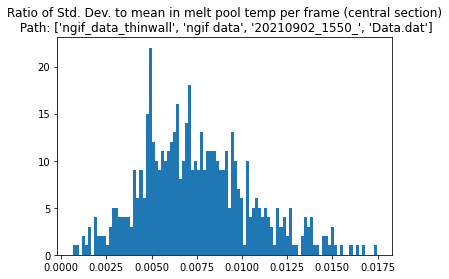

Data path C:\Users\Scott Williams\Documents\programming\ngif_romar\data\ngif_data_thinwall\ngif data\20210906_0918_\Data.dat
['Data.dat', 'Frames']
Number of rows: 6906, head:


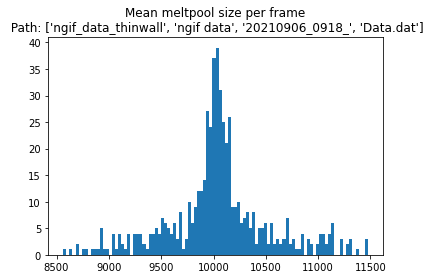

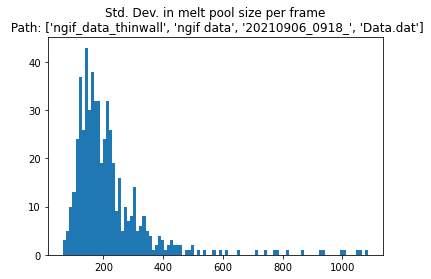

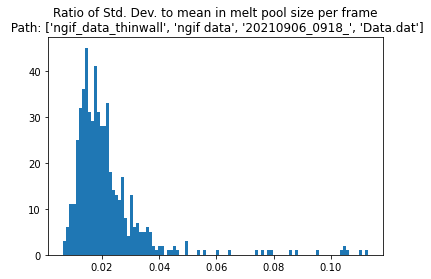

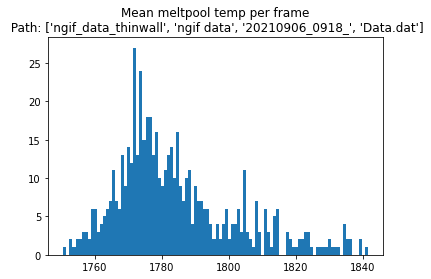

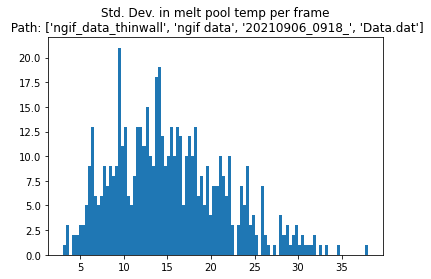

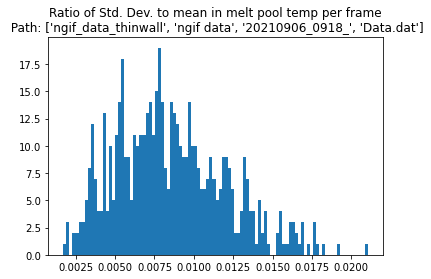

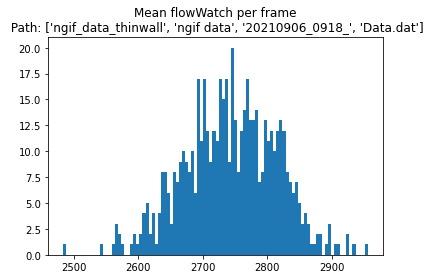

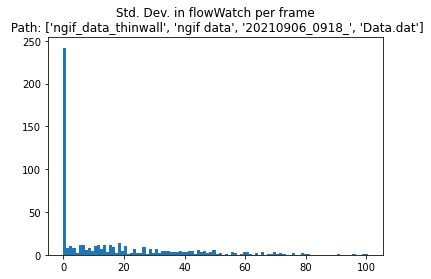

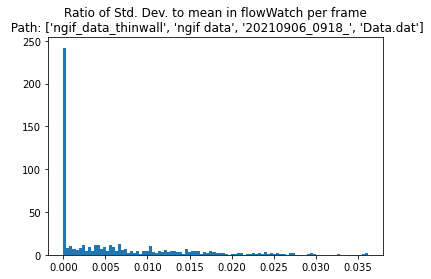

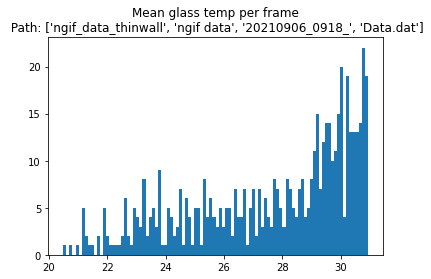

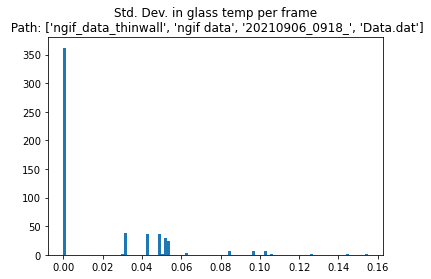

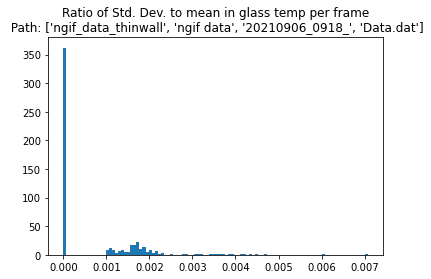

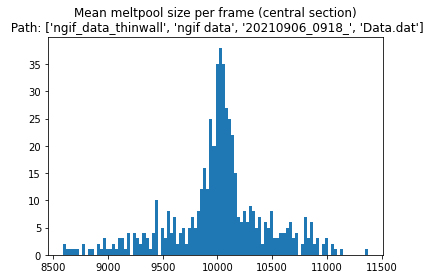

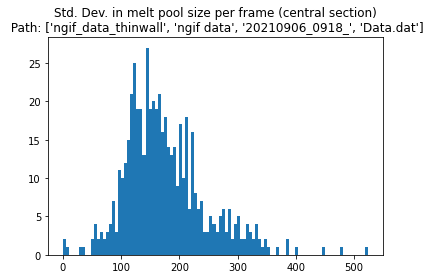

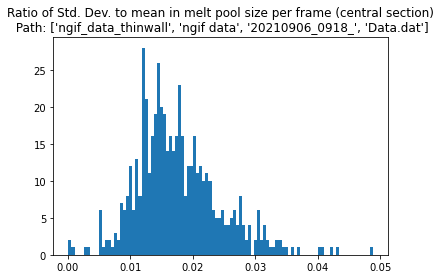

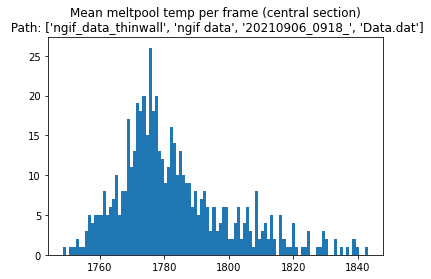

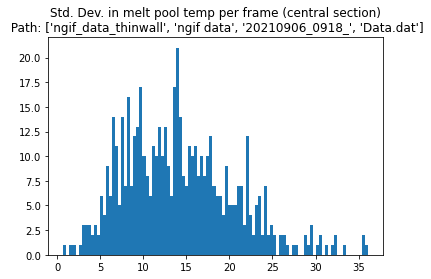

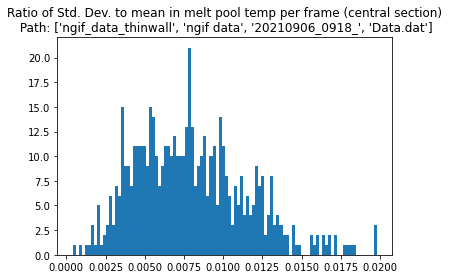

Data path C:\Users\Scott Williams\Documents\programming\ngif_romar\data\ngif_data_thinwall\ngif data\20210906_1019_\Data.dat
['Data.dat', 'Frames']
Number of rows: 6907, head:


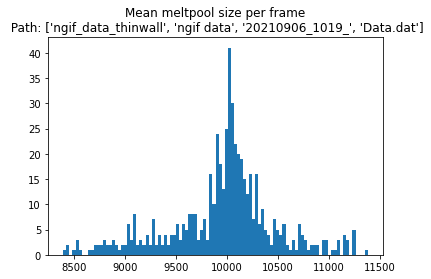

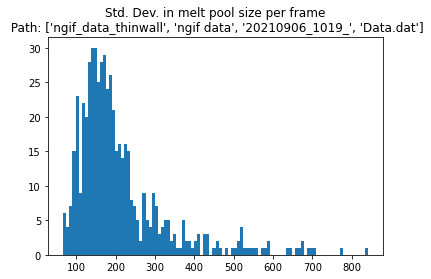

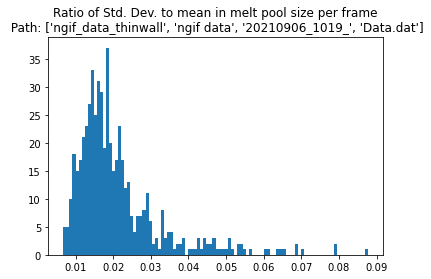

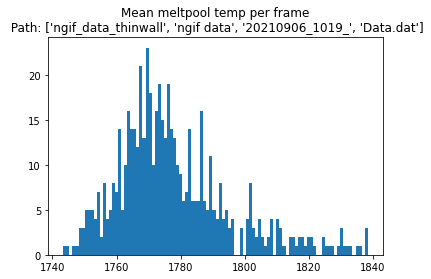

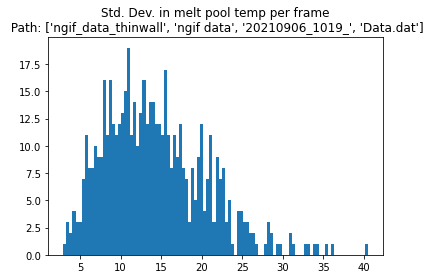

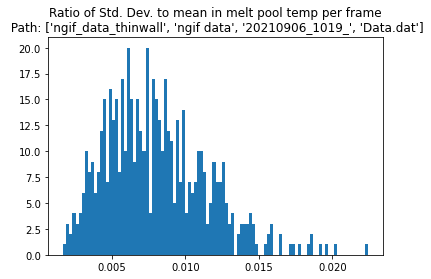

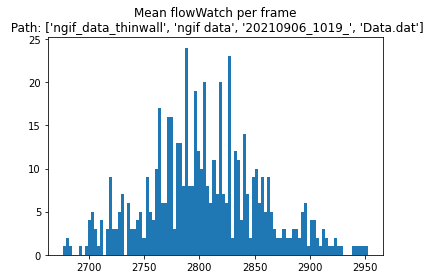

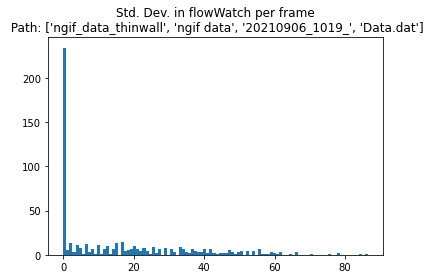

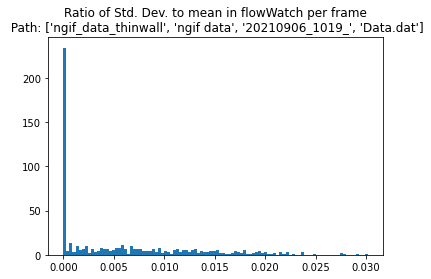

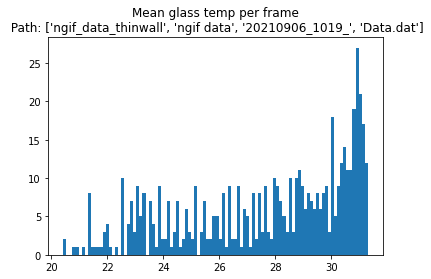

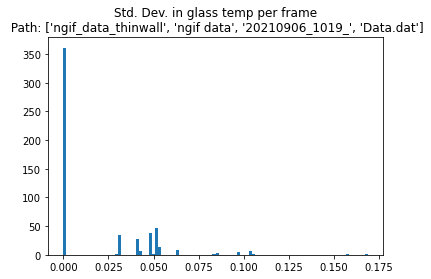

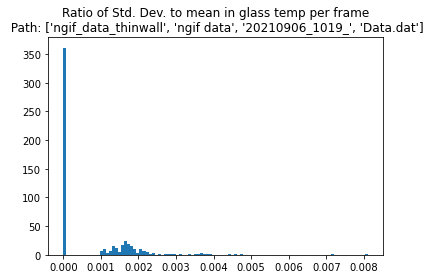

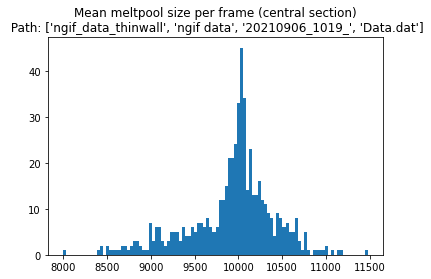

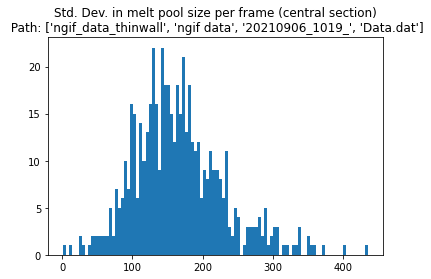

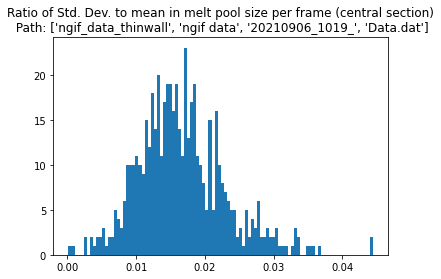

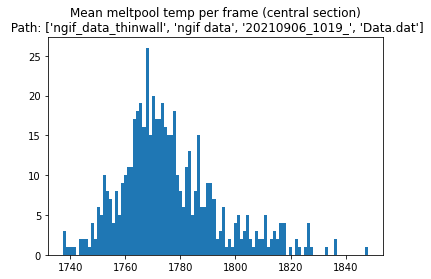

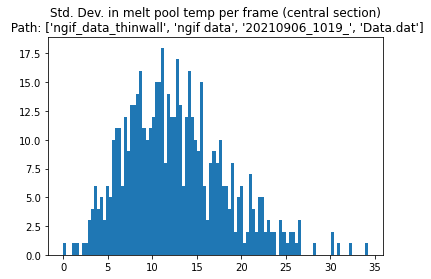

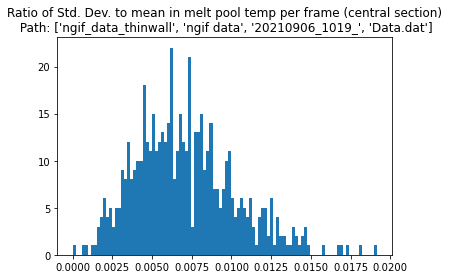

Data path C:\Users\Scott Williams\Documents\programming\ngif_romar\data\ngif_data_thinwall\ngif data\20210906_1339_\Data.dat
['Data.dat', 'Frames']
Number of rows: 6907, head:


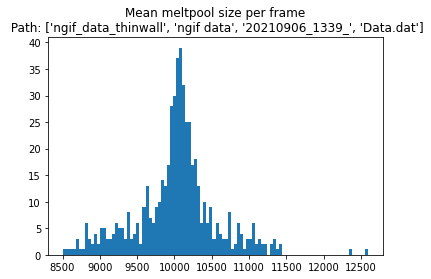

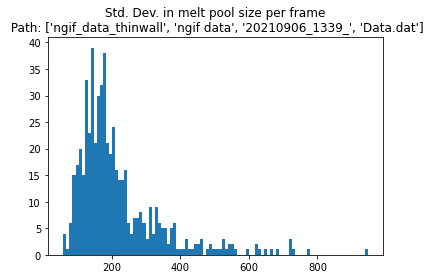

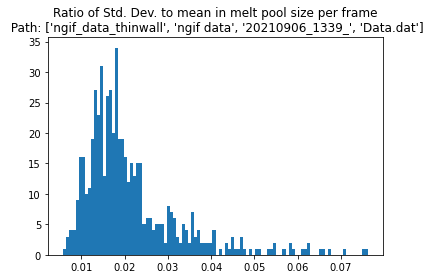

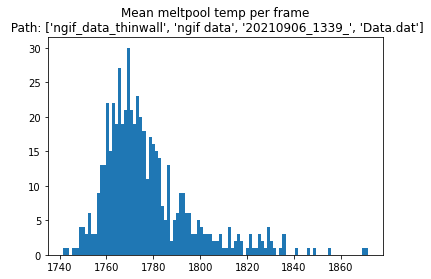

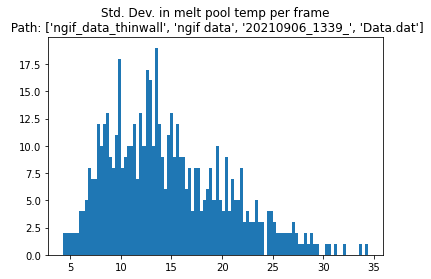

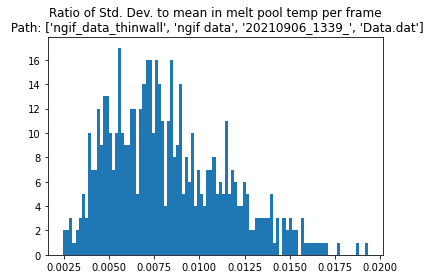

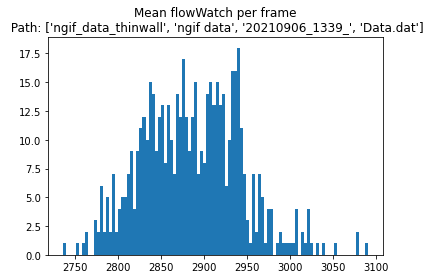

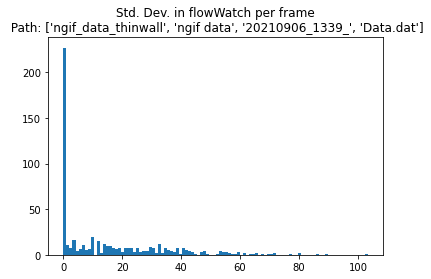

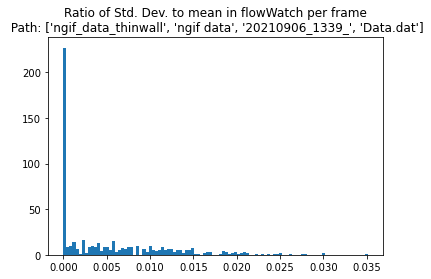

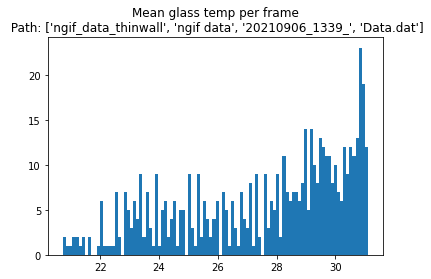

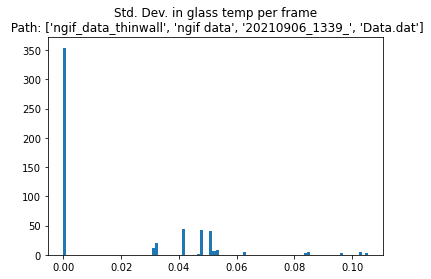

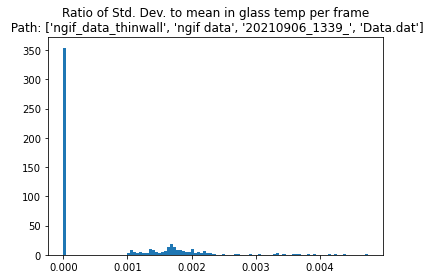

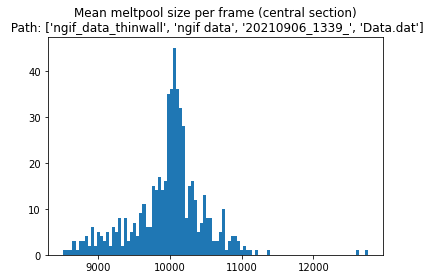

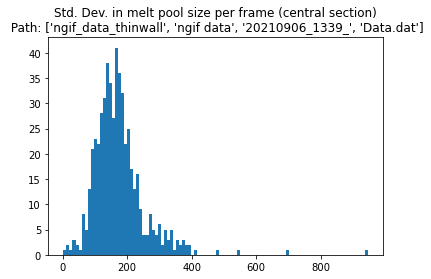

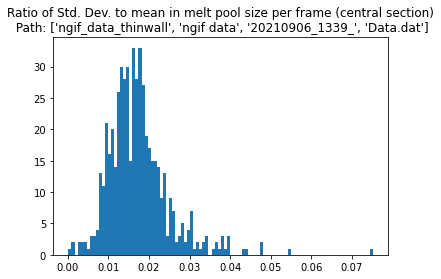

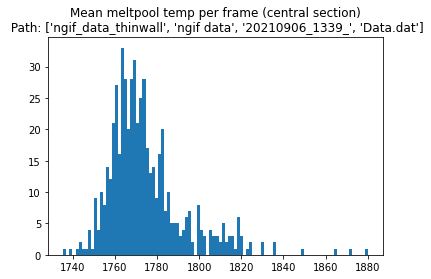

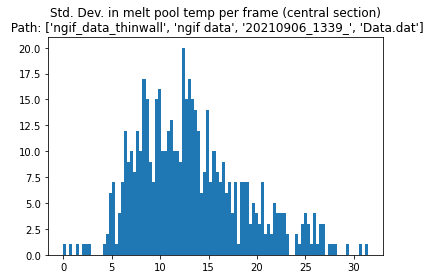

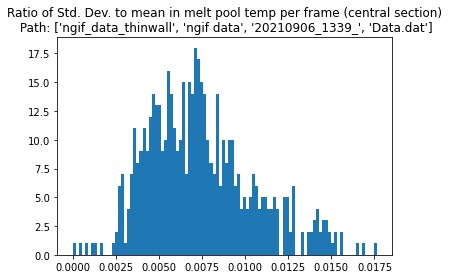

Data path C:\Users\Scott Williams\Documents\programming\ngif_romar\data\ngif_data_thinwall\ngif data\20210913_0928_\Data.dat
['Data.dat', 'Frames']
Number of rows: 6912, head:


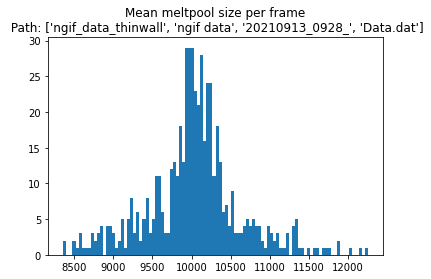

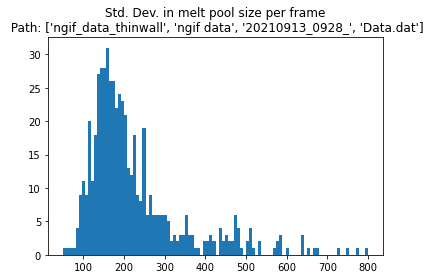

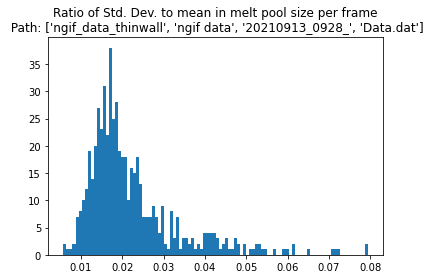

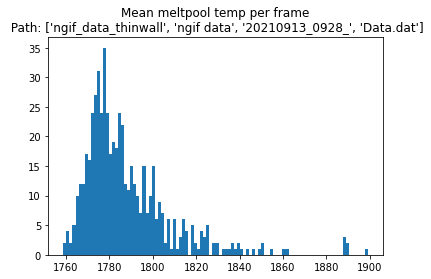

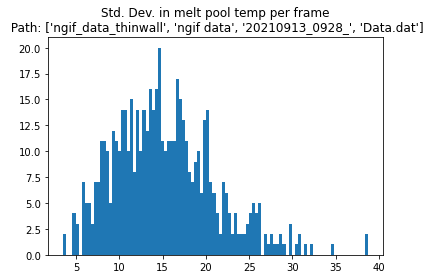

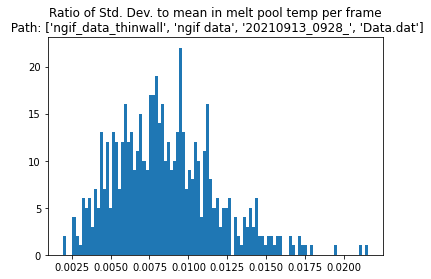

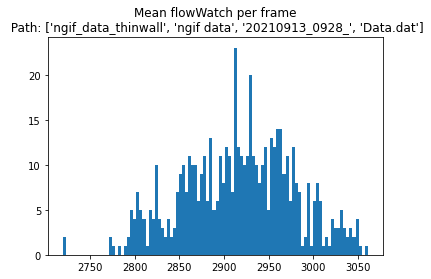

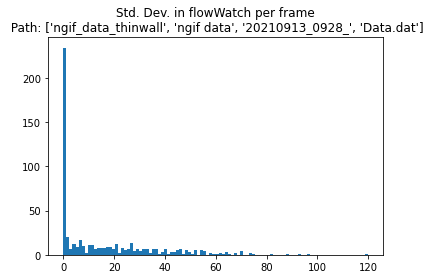

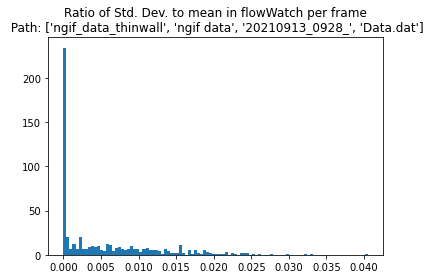

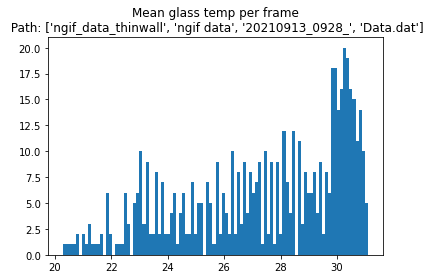

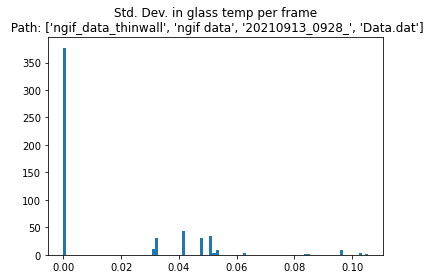

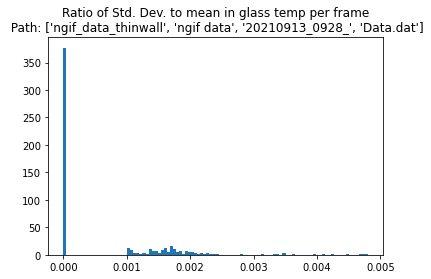

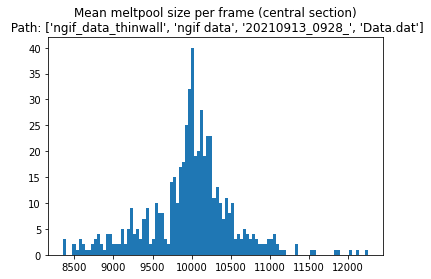

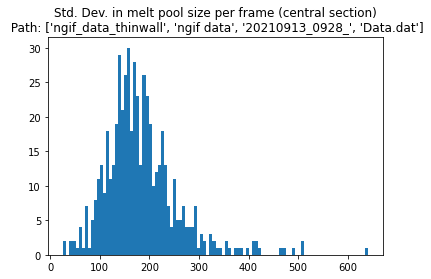

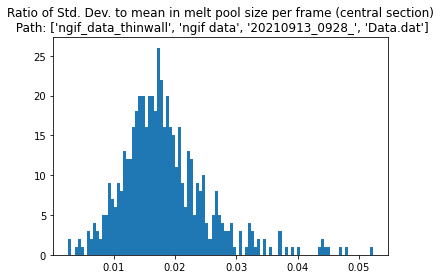

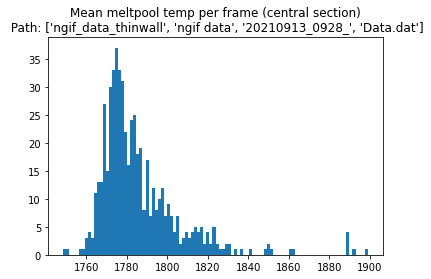

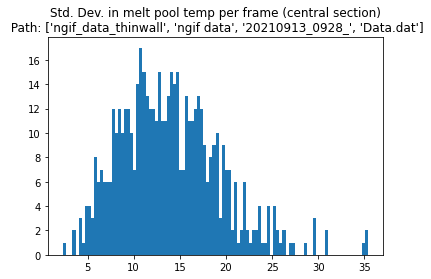

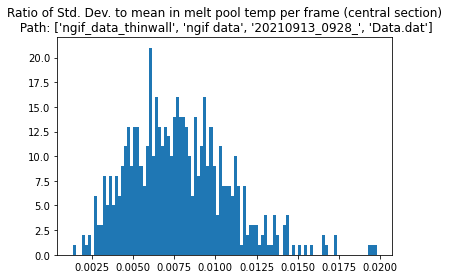

Data path C:\Users\Scott Williams\Documents\programming\ngif_romar\data\ngif_data_thinwall\ngif data\ngif-wall\Data.dat
['Data.dat', 'Frames']
Number of rows: 6885, head:


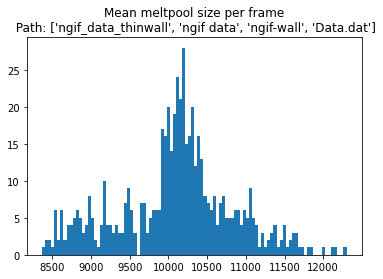

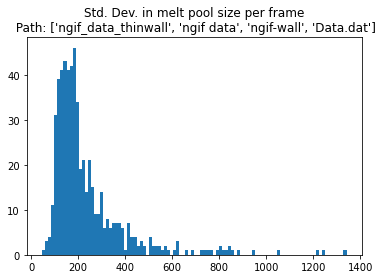

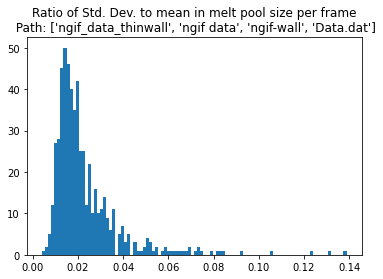

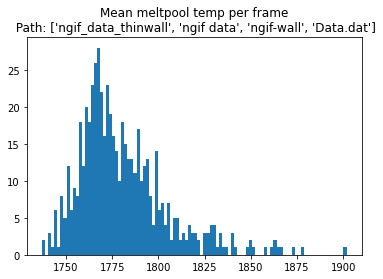

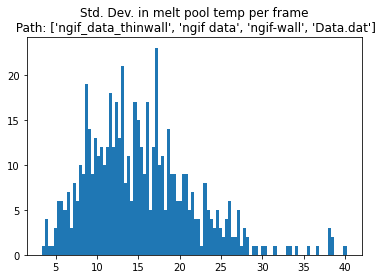

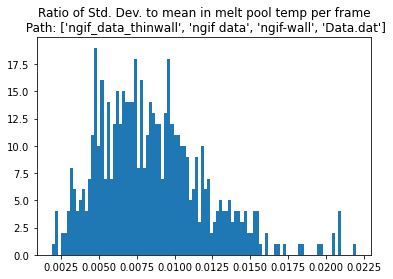

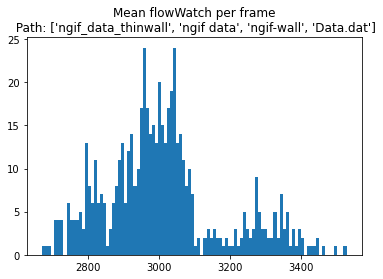

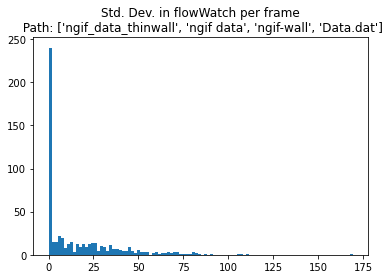

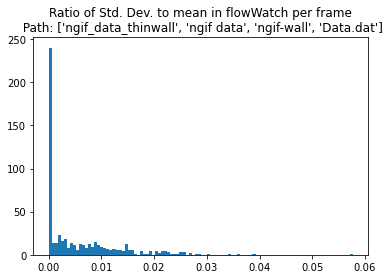

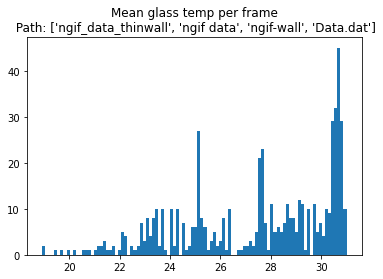

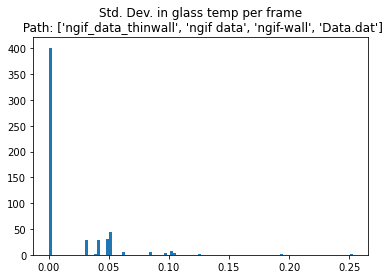

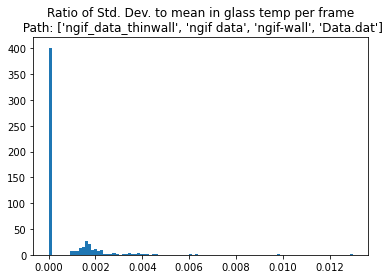

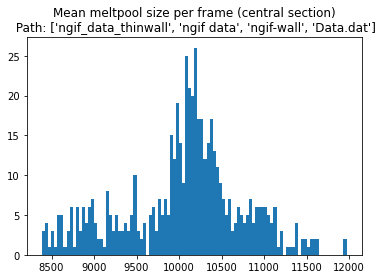

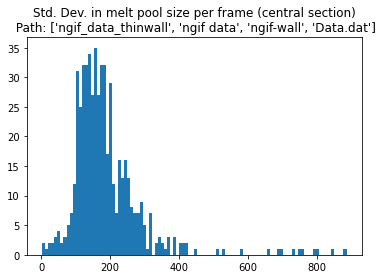

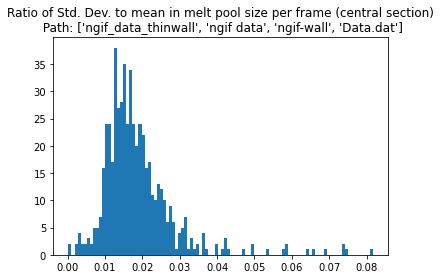

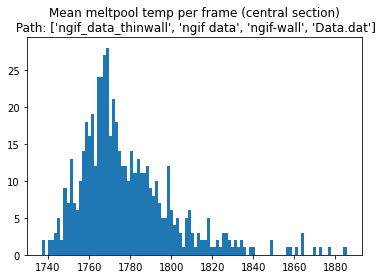

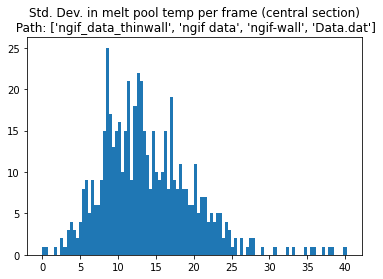

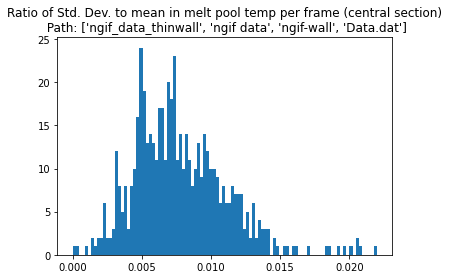

In [27]:
ngif_thinwall_parent_path = os.path.abspath(os.path.join(
    "..",
    "data",
    "ngif_data_thinwall",
    "ngif data"
))
if os.path.isdir(ngif_thinwall_parent_path):
    print(os.listdir(ngif_thinwall_parent_path))
    
for i in os.listdir(ngif_thinwall_parent_path):
    if not os.path.isdir(os.path.join(ngif_thinwall_parent_path, i)):
        continue
    # Load in data
    logfile_path = os.path.join(ngif_thinwall_parent_path, i, "Data.dat")
    meta_dict, this_data_df = tools.read_data(logfile_path)
    this_data_df = tools.post_process_log_data(this_data_df)
    print(os.listdir(dataset_path))
    frames_path = os.path.join(dataset_path, "Frames")
    this_data_df = tools.link_camera_frames_to_df(this_data_df, frame_folder_path=frames_path)
    print("Number of rows: {}, head:".format(len(this_data_df)))
    
    # Get subset, start groupby
    # Find a list of frames where the laser is off for any part
    laser_off_frames = this_data_df[
        (this_data_df["laser_off_time(ms)"] > 0)
        | (this_data_df["laser_on_time(ms)"] < 200)
    ]["matching_frame_filename"].unique()

    subset = this_data_df[
        ~(this_data_df["matching_frame_filename"].isin(laser_off_frames))
    ]
    
    display_path = logfile_path.split(os.sep)[-4:]
    
    fig, ax = plt.subplots()
    ax.hist(subset.groupby("matching_frame_filename").mean()["meltpoolSize"], bins=100)
    ax.set_title("Mean meltpool size per frame\n Path: {}".format(display_path))
    plt.show()

    fig, ax = plt.subplots()
    ax.hist(subset.groupby("matching_frame_filename").std()["meltpoolSize"], bins=100)
    ax.set_title("Std. Dev. in melt pool size per frame\n Path: {}".format(display_path))
    plt.show()

    fig, ax = plt.subplots()
    ax.hist(subset.groupby("matching_frame_filename").std()["meltpoolSize"] / subset.groupby("matching_frame_filename").mean()["meltpoolSize"], bins=100)
    ax.set_title("Ratio of Std. Dev. to mean in melt pool size per frame\n Path: {}".format(display_path))
    plt.show()



    fig, ax = plt.subplots()
    ax.hist(subset.groupby("matching_frame_filename").mean()["meltpoolTemp"], bins=100)
    ax.set_title("Mean meltpool temp per frame\n Path: {}".format(display_path))
    plt.show()

    fig, ax = plt.subplots()
    ax.hist(subset.groupby("matching_frame_filename").std()["meltpoolTemp"], bins=100)
    ax.set_title("Std. Dev. in melt pool temp per frame\n Path: {}".format(display_path))
    plt.show()

    fig, ax = plt.subplots()
    ax.hist(subset.groupby("matching_frame_filename").std()["meltpoolTemp"] / subset.groupby("matching_frame_filename").mean()["meltpoolTemp"], bins=100)
    ax.set_title("Ratio of Std. Dev. to mean in melt pool temp per frame\n Path: {}".format(display_path))
    plt.show()


    fig, ax = plt.subplots()
    ax.hist(subset.groupby("matching_frame_filename").mean()["flowWatch"], bins=100)
    ax.set_title("Mean flowWatch per frame\n Path: {}".format(display_path))
    plt.show()

    fig, ax = plt.subplots()
    ax.hist(subset.groupby("matching_frame_filename").std()["flowWatch"], bins=100)
    ax.set_title("Std. Dev. in flowWatch per frame\n Path: {}".format(display_path))
    plt.show()

    fig, ax = plt.subplots()
    ax.hist(subset.groupby("matching_frame_filename").std()["flowWatch"] / subset.groupby("matching_frame_filename").mean()["flowWatch"], bins=100)
    ax.set_title("Ratio of Std. Dev. to mean in flowWatch per frame\n Path: {}".format(display_path))
    plt.show()


    fig, ax = plt.subplots()
    ax.hist(subset.groupby("matching_frame_filename").mean()["protectionGlasTemperature"], bins=100)
    ax.set_title("Mean glass temp per frame\n Path: {}".format(display_path))
    plt.show()

    fig, ax = plt.subplots()
    ax.hist(subset.groupby("matching_frame_filename").std()["protectionGlasTemperature"], bins=100)
    ax.set_title("Std. Dev. in glass temp per frame\n Path: {}".format(display_path))
    plt.show()

    fig, ax = plt.subplots()
    ax.hist(subset.groupby("matching_frame_filename").std()["protectionGlasTemperature"] / subset.groupby("matching_frame_filename").mean()["protectionGlasTemperature"], bins=100)
    ax.set_title("Ratio of Std. Dev. to mean in glass temp per frame\n Path: {}".format(display_path))
    plt.show()

    
    
    
    # For thinwall set only: make sure we don't get values near end of travel
    subset_2 = subset[
        np.abs(subset["x"]) < 40
    ]

    fig, ax = plt.subplots()
    ax.hist(subset_2.groupby("matching_frame_filename").mean()["meltpoolSize"], bins=100)
    ax.set_title("Mean meltpool size per frame (central section)\n Path: {}".format(display_path))
    plt.show()

    fig, ax = plt.subplots()
    ax.hist(subset_2.groupby("matching_frame_filename").std()["meltpoolSize"], bins=100)
    ax.set_title("Std. Dev. in melt pool size per frame (central section)\n Path: {}".format(display_path))
    plt.show()

    fig, ax = plt.subplots()
    ax.hist(subset_2.groupby("matching_frame_filename").std()["meltpoolSize"] / subset_2.groupby("matching_frame_filename").mean()["meltpoolSize"], bins=100)
    ax.set_title("Ratio of Std. Dev. to mean in melt pool size per frame (central section)\n Path: {}".format(display_path))
    plt.show()

    fig, ax = plt.subplots()
    ax.hist(subset_2.groupby("matching_frame_filename").mean()["meltpoolTemp"], bins=100)
    ax.set_title("Mean meltpool temp per frame (central section)\n Path: {}".format(display_path))
    plt.show()

    fig, ax = plt.subplots()
    ax.hist(subset_2.groupby("matching_frame_filename").std()["meltpoolTemp"], bins=100)
    ax.set_title("Std. Dev. in melt pool temp per frame (central section)\n Path: {}".format(display_path))
    plt.show()

    fig, ax = plt.subplots()
    ax.hist(subset_2.groupby("matching_frame_filename").std()["meltpoolTemp"] / subset_2.groupby("matching_frame_filename").mean()["meltpoolTemp"], bins=100)
    ax.set_title("Ratio of Std. Dev. to mean in melt pool temp per frame (central section)\n Path: {}".format(display_path))
    plt.show()

    

## Next, the other data sets

Data path C:\Users\Scott Williams\Documents\programming\ngif_romar\data\SN2\20200930_1500_\Data.dat
['Data.dat', 'Frames']
Number of rows: 68304, head:


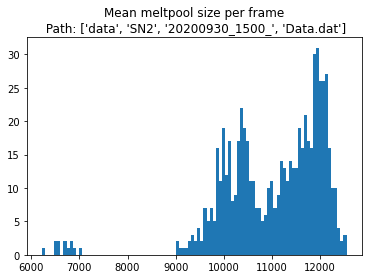

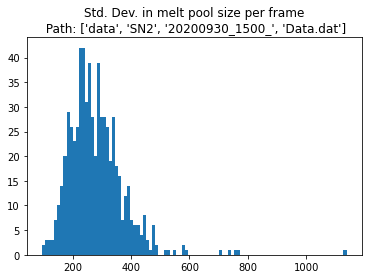

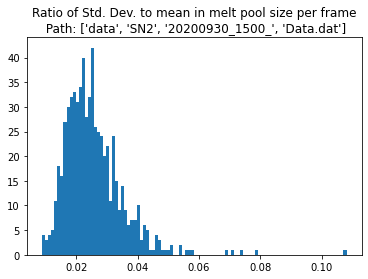

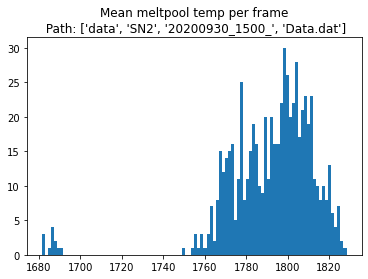

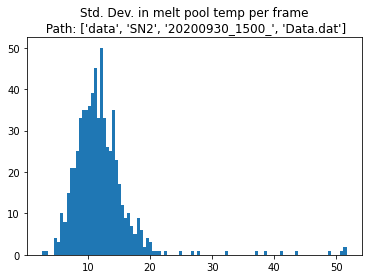

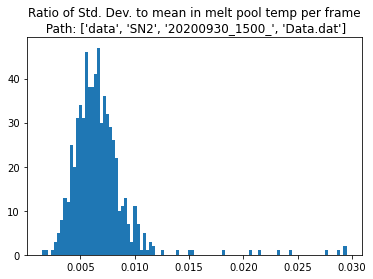

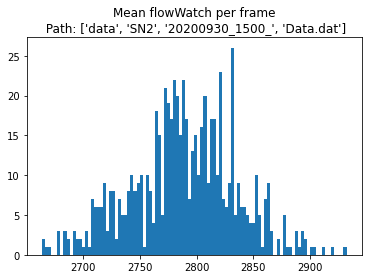

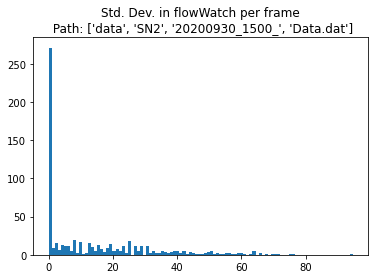

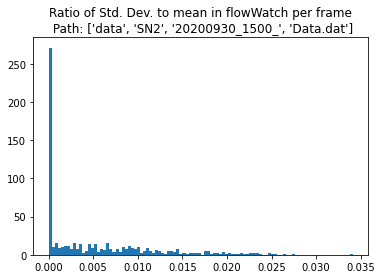

Data path C:\Users\Scott Williams\Documents\programming\ngif_romar\data\SN3\20201002_1152_\Data.dat
['Data.dat', 'Frames']
Number of rows: 63464, head:


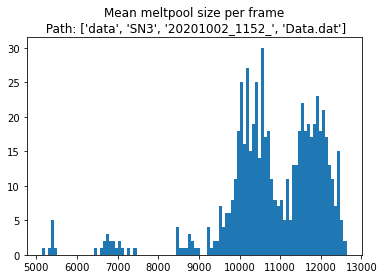

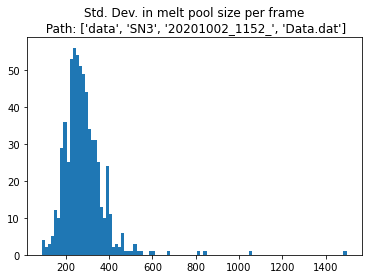

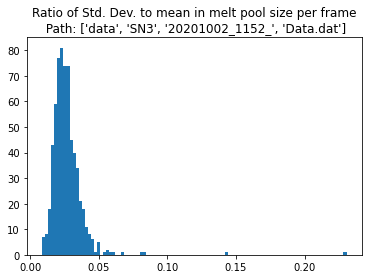

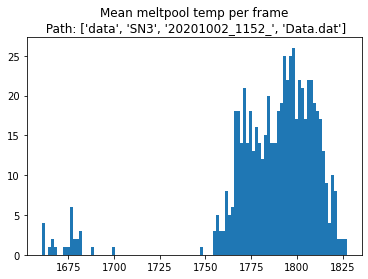

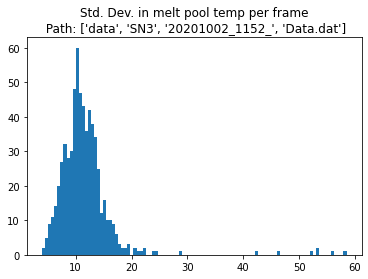

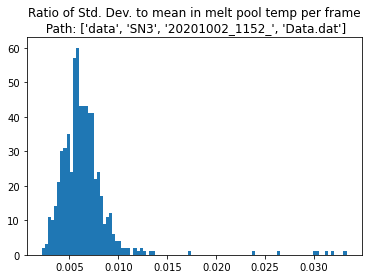

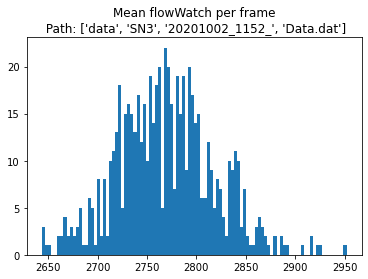

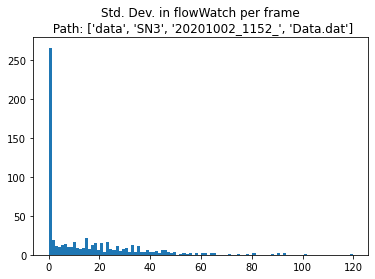

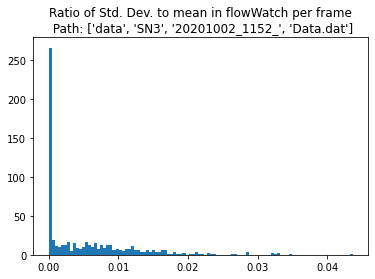

Data path C:\Users\Scott Williams\Documents\programming\ngif_romar\data\SN5\20201022_1359_\Data.dat
['Data.dat', 'Frames']
Number of rows: 35328, head:


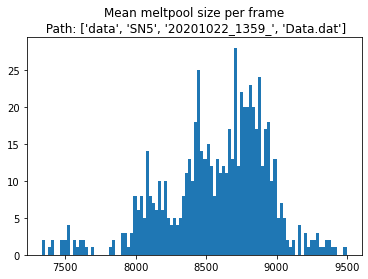

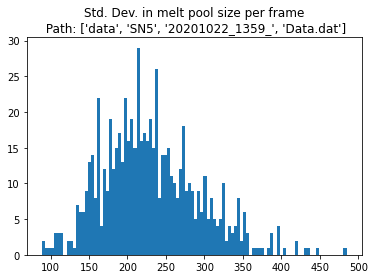

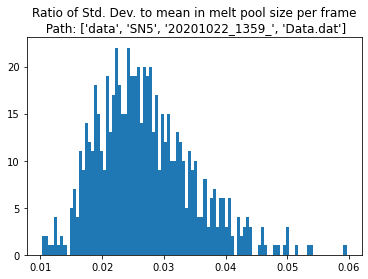

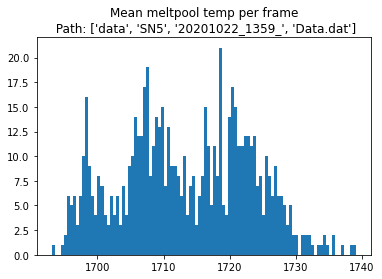

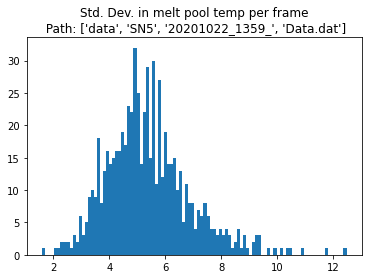

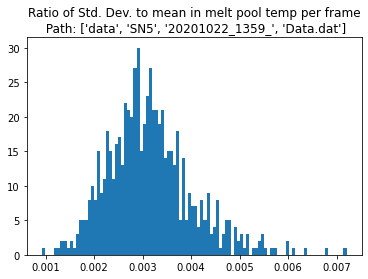

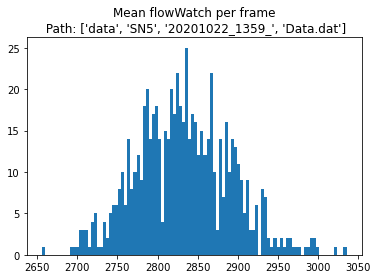

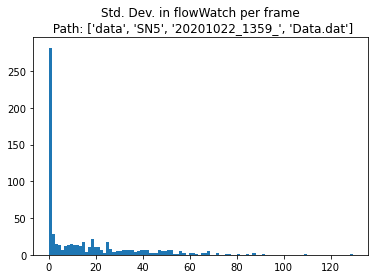

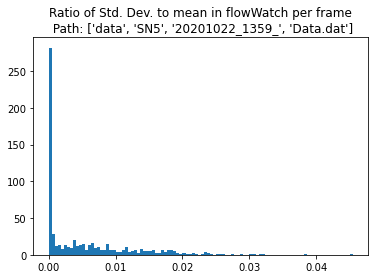

Data path C:\Users\Scott Williams\Documents\programming\ngif_romar\data\SN6\20201023_1426_\Data.dat
['Data.dat', 'Frames']
Number of rows: 35328, head:


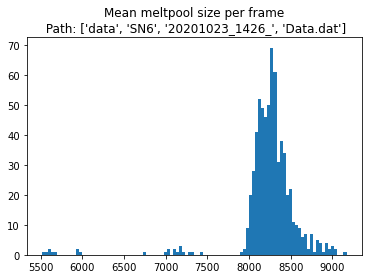

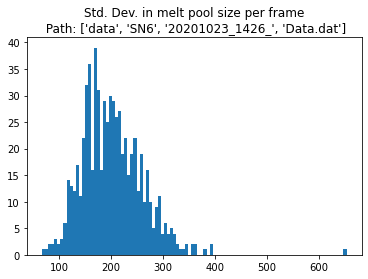

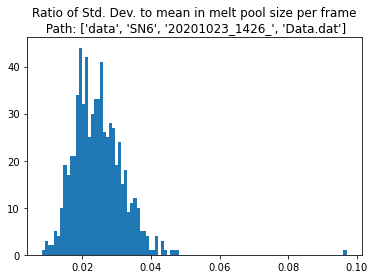

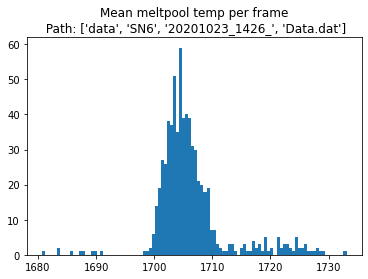

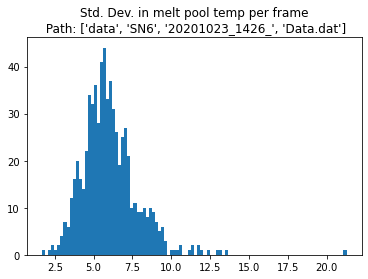

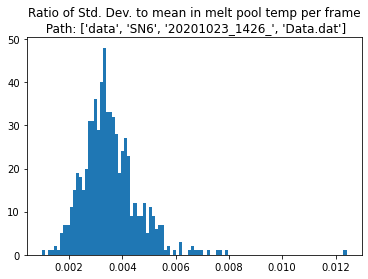

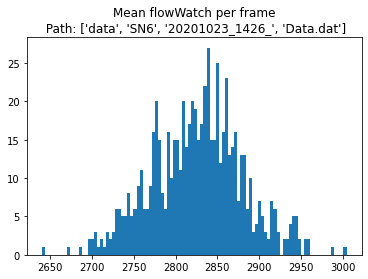

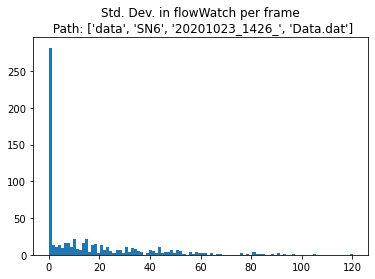

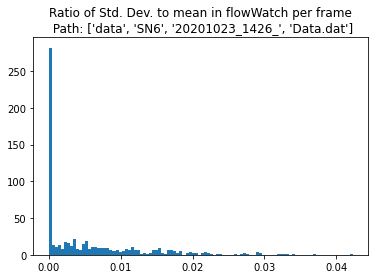

In [28]:
other_data_parent_path = os.path.abspath(os.path.join(
    "..",
    "data",
))    
other_data_set_paths = [os.path.abspath(os.path.join("..", "data", i)) for i in ["SN2", "SN3", "SN5", "SN6"]]

os.listdir(other_data_set_paths[0])
for dataset_parent in other_data_set_paths:
    for folder in os.listdir(dataset_parent):
        # Load data
        logfile_path = os.path.join(dataset_parent, folder, "Data.dat")
        meta_dict, this_data_df = tools.read_data(logfile_path)
        this_data_df = tools.post_process_log_data(this_data_df)
        print(os.listdir(dataset_path))
        frames_path = os.path.join(dataset_path, "Frames")
        this_data_df = tools.link_camera_frames_to_df(this_data_df, frame_folder_path=frames_path)
        print("Number of rows: {}, head:".format(len(this_data_df)))
        
        # Do plots
        laser_off_frames = this_data_df[
            (this_data_df["laser_off_time(ms)"] > 0)
            | (this_data_df["laser_on_time(ms)"] < 200)
        ]["matching_frame_filename"].unique()

        subset = this_data_df[
            ~(this_data_df["matching_frame_filename"].isin(laser_off_frames))
        ]

        display_path = logfile_path.split(os.sep)[-4:]

        fig, ax = plt.subplots()
        ax.hist(subset.groupby("matching_frame_filename").mean()["meltpoolSize"], bins=100)
        ax.set_title("Mean meltpool size per frame\n Path: {}".format(display_path))
        plt.show()

        fig, ax = plt.subplots()
        ax.hist(subset.groupby("matching_frame_filename").std()["meltpoolSize"], bins=100)
        ax.set_title("Std. Dev. in melt pool size per frame\n Path: {}".format(display_path))
        plt.show()

        fig, ax = plt.subplots()
        ax.hist(subset.groupby("matching_frame_filename").std()["meltpoolSize"] / subset.groupby("matching_frame_filename").mean()["meltpoolSize"], bins=100)
        ax.set_title("Ratio of Std. Dev. to mean in melt pool size per frame\n Path: {}".format(display_path))
        plt.show()



        fig, ax = plt.subplots()
        ax.hist(subset.groupby("matching_frame_filename").mean()["meltpoolTemp"], bins=100)
        ax.set_title("Mean meltpool temp per frame\n Path: {}".format(display_path))
        plt.show()

        fig, ax = plt.subplots()
        ax.hist(subset.groupby("matching_frame_filename").std()["meltpoolTemp"], bins=100)
        ax.set_title("Std. Dev. in melt pool temp per frame\n Path: {}".format(display_path))
        plt.show()

        fig, ax = plt.subplots()
        ax.hist(subset.groupby("matching_frame_filename").std()["meltpoolTemp"] / subset.groupby("matching_frame_filename").mean()["meltpoolTemp"], bins=100)
        ax.set_title("Ratio of Std. Dev. to mean in melt pool temp per frame\n Path: {}".format(display_path))
        plt.show()


        fig, ax = plt.subplots()
        ax.hist(subset.groupby("matching_frame_filename").mean()["flowWatch"], bins=100)
        ax.set_title("Mean flowWatch per frame\n Path: {}".format(display_path))
        plt.show()

        fig, ax = plt.subplots()
        ax.hist(subset.groupby("matching_frame_filename").std()["flowWatch"], bins=100)
        ax.set_title("Std. Dev. in flowWatch per frame\n Path: {}".format(display_path))
        plt.show()

        fig, ax = plt.subplots()
        ax.hist(subset.groupby("matching_frame_filename").std()["flowWatch"] / subset.groupby("matching_frame_filename").mean()["flowWatch"], bins=100)
        ax.set_title("Ratio of Std. Dev. to mean in flowWatch per frame\n Path: {}".format(display_path))
        plt.show()
        # 
        break